In [129]:

import uesgraphs as ug

import uesgraphs.analyze as analyze
from uesgraphs.examples import e1_example_readme as e1

import os

from datetime import datetime


workspace = e1.workspace_example("e14")

dir_ues = os.path.dirname(os.path.dirname(workspace))
pinola_json = r"D:\rka-lko\git\transurban_seestadt\dhc_model\workspace\transurban_seestadt_uesgraphs.json"#os.path.join(dir_ues, "workspace", "e11", "inputs","test_modelgen", "Pinola", "nodes.json")
pinola_sim_data = r"D:\rka-lko\work\2025_04_analysis\10042025SeestadtNewSim\Sim20250409_190504_detailed\Sim20250409_190504_1\Results\Sim20250409_190504_1_inputs"# os.path.join(dir_ues,"uesgraphs","data","Pinola_low_temp_network_inputs.mat")

if not os.path.exists(pinola_json):
    raise FileNotFoundError(f"File {pinola_json} not found."
                            "Please run example e11 to generate network topology.")

graph = ug.UESGraph()
graph.from_json(path = pinola_json, network_type="heating")
graph.graph["name"] = "seestadt"
graph.graph["supply_type"] = "supply"

start_date=datetime(2024, 2, 1) 
end_date=datetime(2024, 2, 7)

graph = analyze.assign_data_to_uesgraphs(graph,sim_data = pinola_sim_data,
                                            start_date=start_date,
                                            end_date=end_date,
                                            aixlib_version="2.1.0") #aixlib version is needed to assign data properly



read nodes...
******
 input_ids were {'buildings': None, 'nodes': '0ba1b0eb-e43d-4227-9162-f551989d37a7', 'pipes': None, 'supplies': None}
...finished
Processing: D:\rka-lko\work\2025_04_analysis\10042025SeestadtNewSim\Sim20250409_190504_detailed\Sim20250409_190504_1\Results\Sim20250409_190504_1_inputs.gzip
Assignment of pressure to nodes completed


In [149]:
df = pump_power_analysis(graph, True, r"D:\rka-lko\git\uesgraphs\uesgraphs\examples\output")

df.head()

TypeError: list indices must be integers or slices, not str

In [148]:
import networkx as nx

def calculate_accumulated_pressure_drop(graph,source_node):
    acc_pressures = nx.single_source_dijkstra_path_length(graph, source_node,weight="press_drop")
    max_pressure_node = max(acc_pressures, key=acc_pressures.get)
    max_pressure_value = acc_pressures[max_pressure_node]
    return max_pressure_node, max_pressure_value, acc_pressures

def plot_pump_energy(df, output_dir = None, label=""):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates

    # Convert timestamp to datetime if it's not already
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['cumulative_energy'], label=label)
    
    # Formatting the x-axis for better readability
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()

    plt.title('Cumulative Energy Consumption Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Cumulative Energy (kWh)')
    plt.legend()
    
    if output_dir:
        output_path = os.path.join(output_dir, 'energy_consumption_plot.png')
        plt.savefig(output_path)
        print(f"Plot saved to {output_path}")
    
    plt.show()

def pump_power_analysis(graph, plot =True, output_dir=None, config=None):
    graph, pump_power_df = calculate_pump_power(graph, config)
    pump_energy_df = calculate_pump_energy(pump_power_df)
    if plot:
        plot_pump_energy(pump_energy_df, output_dir)
    if output_dir:
        pump_energy_df.to_csv(os.path.join(output_dir, "pump_energy.csv"), index=True)
    return pump_energy_df

def calculate_pump_power(graph,config=None):
    if not isinstance(graph, ug.UESGraph):
        raise TypeError("graph must be an instance of UESGraph")
    
    default_config = {
        "eta_pump": 0.8,
        "dp_pump": 1000,
        "density_func": lambda t, temp=None: 998    # Default density function for water at 20°C
    }

    if config is None:
        config = {}

    for key, value in default_config.items():
        if key not in config:
            config[key] = value

    # Store results in a list
    results = []

    # Start algorithm by finding supply nodes
    source_nodes,source_edges = find_source_nodes(graph)

    # Right now only one supply node is supported
    for source_node in source_nodes:
        time_index = graph.edges[source_edges[0]]["press_drop"].index
        for t in time_index:
            graph_t = get_graph_at_time(graph, t)
            max_pressure_node, max_pressure_value, acc_pressures = calculate_accumulated_pressure_drop(graph_t, source_node)
            # Calculate pump power using the formula
            # P = (dp * V_dot) / (eta * 1000)
            
                # Calculate density first
            density = config["density_func"](t, temp=graph_t.nodes[source_node]["temperature_supply"]) if callable(config["density_func"]) else config["density_func"]
                # Calculate volume flow rate
            volume_flow = abs(graph_t.edges[list(graph_t.edges(source_node))[0]]["m_flow"]) / density
            
                # Calulate total pressure drop
            dp_pump = config["dp_pump"] # Pump pressure drop
            dp_tot = max_pressure_value*2 + dp_pump # Since supply and return side share the same ppressure drop => *2
            # Calculate pump power
            eta_pump = config["eta_pump"]
            pump_power = (dp_tot * volume_flow) / (eta_pump * 1000)

            # Append results
            results.append({
                    'timestamp': t,
                    'source_node': source_node,
                    'max_pressure_node': max_pressure_node,
                    'max_pressure_value': max_pressure_value,
                    'dp_tot': dp_tot,
                    'volume_flow': volume_flow,
                    'pump_power': pump_power,
                    'rho': density,
                    'eta_pump': eta_pump,
                    'dp_pump': dp_pump,
                })
            result_entry = {}
            for node, pressure in acc_pressures.items():
                result_entry[f'pressure_{node}'] = float(pressure)
            results.append(resut_entry)
    # Create a DataFrame from the results
        pump_power_df = pd.DataFrame(results)
    return graph, pump_power_df

In [111]:


def find_source_nodes(graph):
    source_nodes = []
    source_edges = []
    for node in list(graph.nodes):
        if "is_supply_heating" in graph.nodes[node]:
            if graph.nodes[node]["is_supply_heating"] == True:
                source_nodes.append(node)
                source_edges.append(list(graph.edges(node))[0])
    if len(source_nodes) > 1:
        print(f"More than one source node found in graph {graph.graph['name']}.")
    elif len(source_edges) == 0:
        print(f"No source edges found in graph {graph.graph['name']}.")
        raise ValueError(f"No source edges found in graph and no pump power calc possible {graph.graph['name']}.")
    return source_nodes, source_edges
    

def find_max_acc_pressure_drop(graph):
    max_press_drop = 0.0
    for edge in list(graph.edges):
        if "acc_press_drop" in graph.edges[edge]:
            if graph.edges[edge]["acc_press_drop"].max() > max_press_drop:
                max_press_drop = graph.edges[edge]["acc_press_drop"].max()
    return max_press_drop

import numpy as np

# Calculate energy (assuming timestamps are regular with hour intervals)
def calculate_pump_energy(pump_power_df):
    # Sort by timestamp to ensure chronological order
    sorted_df = pump_power_df.sort_values('timestamp')
    
    # Calculate time differences in hours
    sorted_df['time_diff'] = sorted_df['timestamp'].diff().fillna(pd.Timedelta(hours=0))
    sorted_df['time_diff_hours'] = sorted_df['time_diff'].dt.total_seconds() / 3600
    
    # Calculate energy for each interval (kWh)
    sorted_df['energy'] = sorted_df['pump_power'] * sorted_df['time_diff_hours']
    
    # Calculate cumulative energy
    sorted_df['cumulative_energy'] = sorted_df['energy'].cumsum()
    
    return sorted_df
def get_density():
    # Assuming the density of water at 60°C is approximately 983.2 kg/m³
    return 983.2


def get_graph_at_time(graph,time_point):
    snapshot = graph.copy()
    for u,v, data in snapshot.edges(data=True):
        for key in data:
            if isinstance(data[key], pd.Series):
                snapshot[u][v][key] = data[key].loc[time_point]
    return snapshot
time_index = graph.edges[source_edges[0]]["m_flow"].index
for t in time_index:
        graph_t = get_graph_at_time(graph,t) 


eta_pump = 0.8
dp_pump = 0.1
rho = get_density()

results = []

source_nodes, source_edges = find_source_nodes(graph)

def calculate_accumulated_pressure_drop(graph,source_nodes,source_edges):
    for source_node in source_nodes:
        time_index = graph.edges[source_edges[0]]["m_flow"].index
        for t in time_index:
            graph_t = get_graph_at_time(graph, t)
            acc_pressures = nx.single_source_dijkstra_path_length(graph_t, source_node,weight="press_drop")
            max_pressure_node = max(acc_pressures, key=acc_pressures.get)
            max_pressure_value = acc_pressures[max_pressure_node]
            volume_flow = abs(graph_t.edges[list(graph_t.edges(source_node))[0]]["m_flow"]) / rho

            dp_tot = max_pressure_value*2 + dp_pump

            P_el = (dp_tot * volume_flow) / (eta_pump * 1000)
                        # Store all relevant information
            results.append({
                    'timestamp': t,
                    'source_node': source_node,
                    'max_pressure_node': max_pressure_node,
                    'dp_tot': dp_tot,
                    'volume_flow': volume_flow,
                    'pump_power': P_el,
                    'rho': rho,
                    'eta_pump': eta_pump,
                    'dp_pump': dp_pump,
                })
        pump_power_df = pd.DataFrame(results)
    return graph, pump_power_df

In [159]:
result = {}
for node, pressure in acc_pressures.items():
    result[f'pressure_{node}'] = float(pressure)
result

{'pressure_1009': 0.0,
 'pressure_1001': 0.0,
 'pressure_1006': 46.015625,
 'pressure_1008': 46.015625,
 'pressure_1010': 46.015625,
 'pressure_1003': 93.875,
 'pressure_1002': 244.4375,
 'pressure_1011': 244.4375,
 'pressure_1004': 382.125,
 'pressure_1007': 644.0625,
 'pressure_1012': 644.0625,
 'pressure_1005': 983.9375,
 'pressure_1013': 983.9375}

In [90]:
pump_power_df = calculate_energy(pump_power_df)

C:\Users\rka-lko\AppData\Local\Temp\ipykernel_32984\3477975018.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


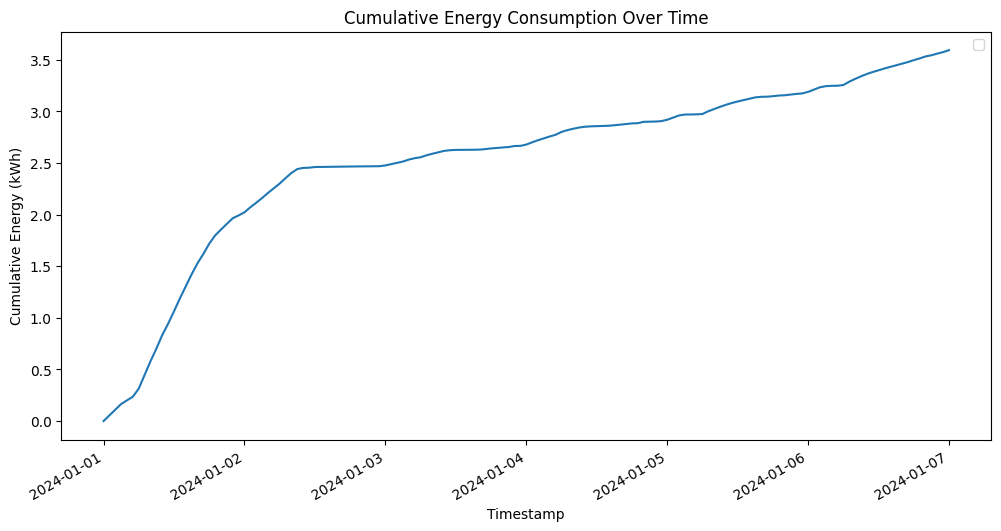

In [91]:
plot_energy_consumption(pump_power_df)

In [76]:
graph.edges

EdgeView([(1001, 1005), (1001, 1006), (1001, 1009), (1002, 1003), (1002, 1004), (1002, 1011), (1003, 1008), (1004, 1007), (1005, 1013), (1006, 1008), (1006, 1010), (1007, 1012)])

In [68]:
import pandas as pd

    

In [2]:

def find_source_node(heat_net):
    nodes = sorted(heat_net.nodes)
    for node in nodes:
        name = heat_net.nodes[node]["name"]
        if isinstance(name, str):
            if name.lower() == "supply1":
                edge =  heat_net.edges(node) #Find adjacent edges
                if len(edge) == 1:
                    return node, list(edge)[0]
                else:
                    logger.error(f"Source node {node} has more than one edge. Check graph")
    return "no source (name = supply1) node found. Please make sure your json file has a node with the name supply1 and only one edge connected to it."

def calculate_accumulated_pressure_drop(heat_nets, source_node, key):
    for heat_net in heat_nets:
        #Calculate the accumulated pressure drops from source node to all other nodes
        pressure = nx.single_source_dijkstra_path_length(heat_net, source_node, weight=key)
        for nodes in heat_net.nodes():
            heat_net.nodes[nodes]["acc_press_drop"] = pressure[nodes]
    return heat_nets

source_node, source_edge = find_source_node(graph)
calculate_accumulated_pressure_drop([graph], source_node, "press_drop")



ValueError: too many values to unpack (expected 2)

In [ ]:
create_uesgraph_visualizer(graph)

In [85]:
   
EDGE_ATTRIBUTES = {
    # Static attributes
    "diameter": {"unit": None, "description": "Pipe inner diameter", "is_timeseries": False},
    "length": {"unit": None, "description": "Pipe length", "is_timeseries": False},
    "pipeID": {"unit": None, "description": "Pipe identifier", "is_timeseries": False},
    "name": {"unit": None, "description": "Pipe name", "is_timeseries": False},
    "node_0": {"unit": None, "description": "Start node identifier", "is_timeseries": False},
    "node_1": {"unit": None, "description": "End node identifier", "is_timeseries": False},
    "dIns": {"unit": "m", "description": "Insulation diameter", "is_timeseries": False},
    "kIns": {"unit": "W/(m·K)", "description": "Insulation thermal conductivity", "is_timeseries": False},
    "m_flow_nom": {"unit": "kg/s", "description": "Nominal mass flow rate", "is_timeseries": False},
    "fac": {"unit": None, "description": "Flow factor", "is_timeseries": False},
    
    # Time series attributes
    "m_flow": {"name": "Mass Flow", "unit": "kg/s", "description": "Mass flow rate", "is_timeseries": True},
    "press_drop": {"name": "Pressure drop", "unit": "Pa", "description": "Pressure drop", "is_timeseries": True},
    "press_drop_length": {"name": "Pressure drop per length", "unit": "Pa/m", "description": "Pressure drop per length", "is_timeseries": True},
    "temp_diff": {"name": "Temperature difference", "unit": "K", "description": "Temperature difference over edge", "is_timeseries": True},
    #"asd": {"unit": None, "description": "asd", "is_timeseries": True}
}
NODE_ATTRIBUTES = {
    # Static attributes
    "node_type": {"unit": None, "description": "Type of the network node", "is_timeseries": False},
    "network_id": {"unit": None, "description": "Network identifier", "is_timeseries": False},
    "position": {"unit": None, "description": "Geographical position coordinates", "is_timeseries": False},
    "name": {"unit": None, "description": "Node name", "is_timeseries": False},
    "press_name": {"unit": None, "description": "Reference name for pressure data", "is_timeseries": False},
    "temp_name": {"unit": None, "description": "Reference name for temperature data", "is_timeseries": False},
   
    # Time series attributes
    "press_flow": {"name": "Pressure", "unit": "Pa", "description": "Pressure flow time series", "is_timeseries": True},
    "temperature_supply": {"name": "Temperature","unit": "K", "description": "Supply temperature time series", "is_timeseries": True},

    # Supply attributes
    "T_supply": {
        "name": "Supply Temperature",
        "unit": "K", 
        "description": "Supply temperature time series", 
        "is_timeseries": False
    },
    "dT_design": {
        "name": "Design Temperature Difference",
        "unit": "K", 
        "description": "Design temperature difference between supply and return", 
        "is_timeseries": False
    },
    "input_heat": {
        "name": "Heat Input",
        "unit": "kW", 
        "description": "Heat input time series", 
        "is_timeseries": False
    },
    "is_supply_cooling": {
        "name": "Cooling Supply Indicator",
        "unit": None, 
        "description": "Boolean flag indicating if the supply is for cooling", 
        "is_timeseries": False
    },
    "is_supply_electricity": {
        "name": "Electricity Supply Indicator",
        "unit": None, 
        "description": "Boolean flag indicating if the supply is electricity", 
        "is_timeseries": False
    },
    "is_supply_gas": {
        "name": "Gas Supply Indicator",
        "unit": None, 
        "description": "Boolean flag indicating if the supply is gas", 
        "is_timeseries": False
    },
    "is_supply_heating": {
        "name": "Heating Supply Indicator",
        "unit": None, 
        "description": "Boolean flag indicating if the supply is for heating", 
        "is_timeseries": False
    },
    "is_supply_other": {
        "name": "Other Supply Indicator",
        "unit": None, 
        "description": "Boolean flag indicating if the supply is from another source", 
        "is_timeseries": False
    },
    "p_supply": {
        "name": "Supply Pressure",
        "unit": "Pa", 
        "description": "Supply pressure time series", 
        "is_timeseries": False
    }
}


In [67]:
EDGE_ATTRIBUTES[attribute]["name"]

'Mass Flow'

In [44]:
graph.edges[1001,1006]["m_flow"]

DateTime
2024-01-01 00:00:00    0.196914
2024-01-01 01:00:00    0.136173
2024-01-01 02:00:00    0.132721
2024-01-01 03:00:00    0.138158
2024-01-01 04:00:00    0.207043
                         ...   
2024-01-06 20:00:00    0.211615
2024-01-06 21:00:00    0.206302
2024-01-06 22:00:00    0.145928
2024-01-06 23:00:00    0.155562
2024-01-07 00:00:00    0.093189
Freq: h, Name: networkModel.pipe1.port_a.m_flow, Length: 145, dtype: float32

In [54]:
if selection["type"] == "edge":
        for edge in list(graph.edges):
            print(f'{edge}: {graph.edges[edge][selection["attribute"]][selection["timestamp"]]}')

(1001, 1006): 0.1969144642353058
(1002, 1008): 0.17965686321258545
(1003, 1006): -0.2985728979110718
(1004, 1007): -0.05367259308695793
(1005, 1008): -0.02432582899928093
(1006, 1007): -0.012064487673342228
(1006, 1008): -0.08959395438432693
(1007, 1008): -0.06573708355426788


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Selected timestamp: 2024-01-01 00:00:00
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\Visuals_20250409_161041.log


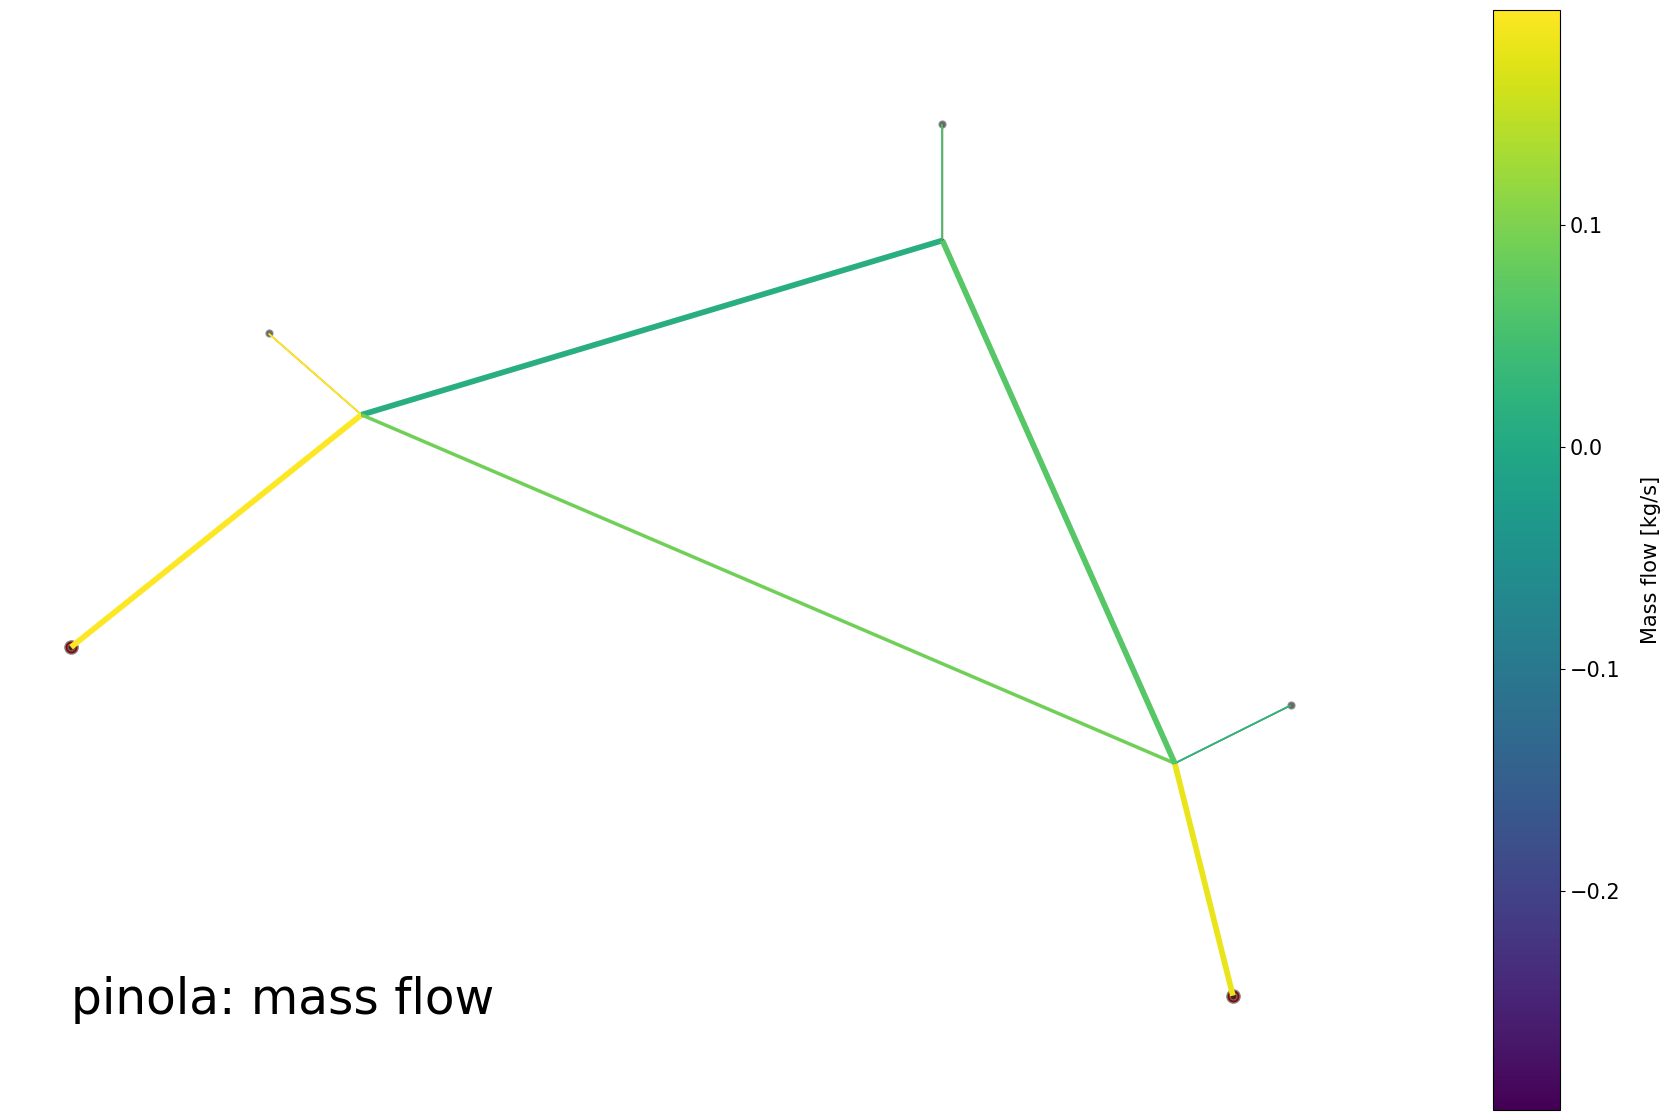

In [89]:
get_selection = create_attribute_selector(graph,EDGE_ATTRIBUTES, NODE_ATTRIBUTES)
selection = get_selection()
type = selection['type']
attribute = selection['attribute']
is_timeseries = selection['is_timeseries']
in_schema = selection['is_in_schema']
in_graph = selection['is_in_graph']

if 'timestamp' in selection:
    print(f"Selected timestamp: {selection['timestamp']}")
    if selection["type"] == "edge":
        for edge in list(graph.edges):
            graph.edges[edge]["to_plot"] = graph.edges[edge][selection["attribute"]][selection["timestamp"]]
        vis = ug.Visuals(graph)
        vis.show_network(show_plot=True,
                           scaling_factor=1,
                           scaling_factor_diameter=50,
                           label_size=15,
                           ylabel="Mass flow [kg/s]",
                           generic_extensive_size="to_plot",
                           #save_as=os.path.join(workspace, "m_flow.png"),
                           timestamp=f"{graph.graph["name"]}: mass flow"
                           )
    elif selection["type"] == "node":
        for node in list(graph.nodes):
            graph.nodes[node]["to_plot"] = graph.nodes[node][selection["attribute"]][selection["timestamp"]]
        vis = ug.Visuals(graph)
        vis.show_network(show_plot=True,
                           scaling_factor=1,
                           scaling_factor_diameter=50,
                           label_size=15,
                          # ylabel=f"{NODE_ATTRIBUTES[]"Mass flow [kg/s]",
                           generic_extensive_size="to_plot",
                           #save_as=os.path.join(workspace, "m_flow.png"),
                           timestamp=f"{graph.graph["name"]}: mass flow"
                           )

In [75]:
widget, get_selection = create_attribute_selector(graph, EDGE_ATTRIBUTES, NODE_ATTRIBUTES)
display(widget)
get_selection()


{'type': 'edge',
 'attribute': 'm_flow',
 'is_in_schema': True,
 'is_in_graph': True,
 'is_timeseries': True}

In [100]:
# Create the attribute selector widget
attr_widget, get_selection, timeseries_analysis = create_attribute_selector(
    graph, EDGE_ATTRIBUTES, NODE_ATTRIBUTES
)

# Display both widgets
display(attr_widget)


selection = get_selection()


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Selected timestamp: 2024-01-01 00:00:00
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\Visuals_20250409_163809.log


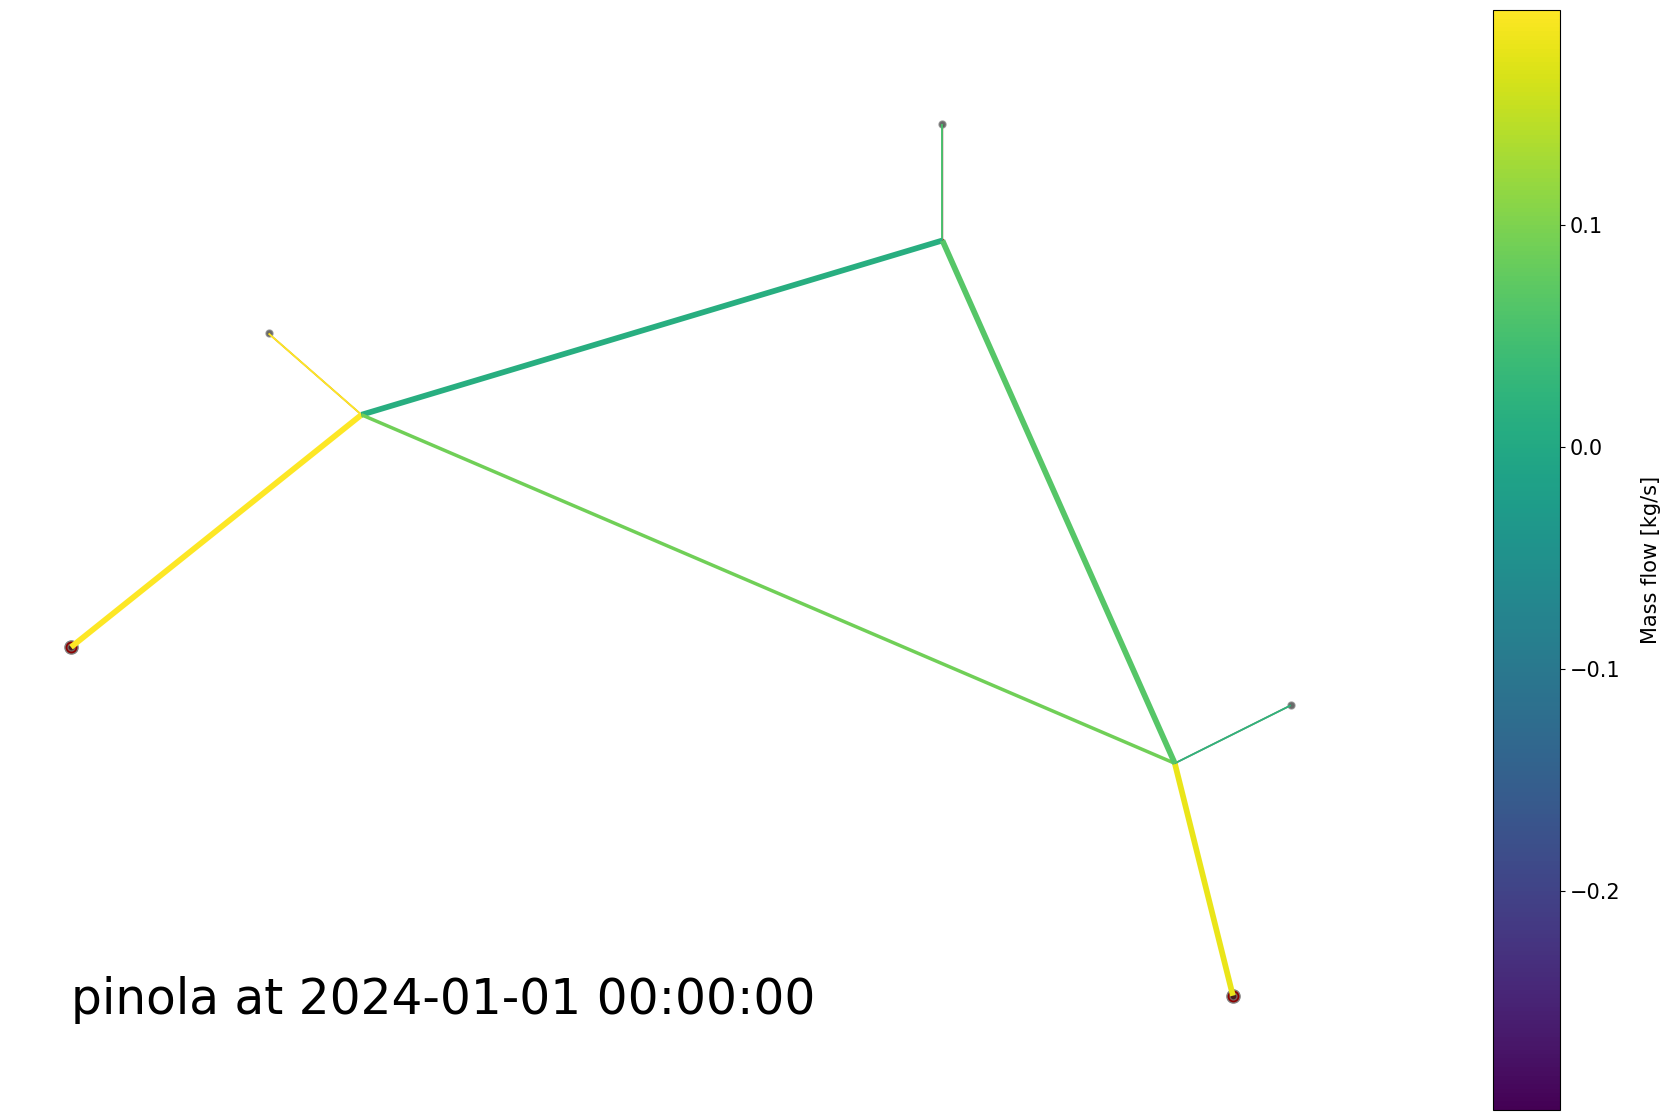

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Selected timestamp: 2024-01-03 07:00:00
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\Visuals_20250409_163815.log


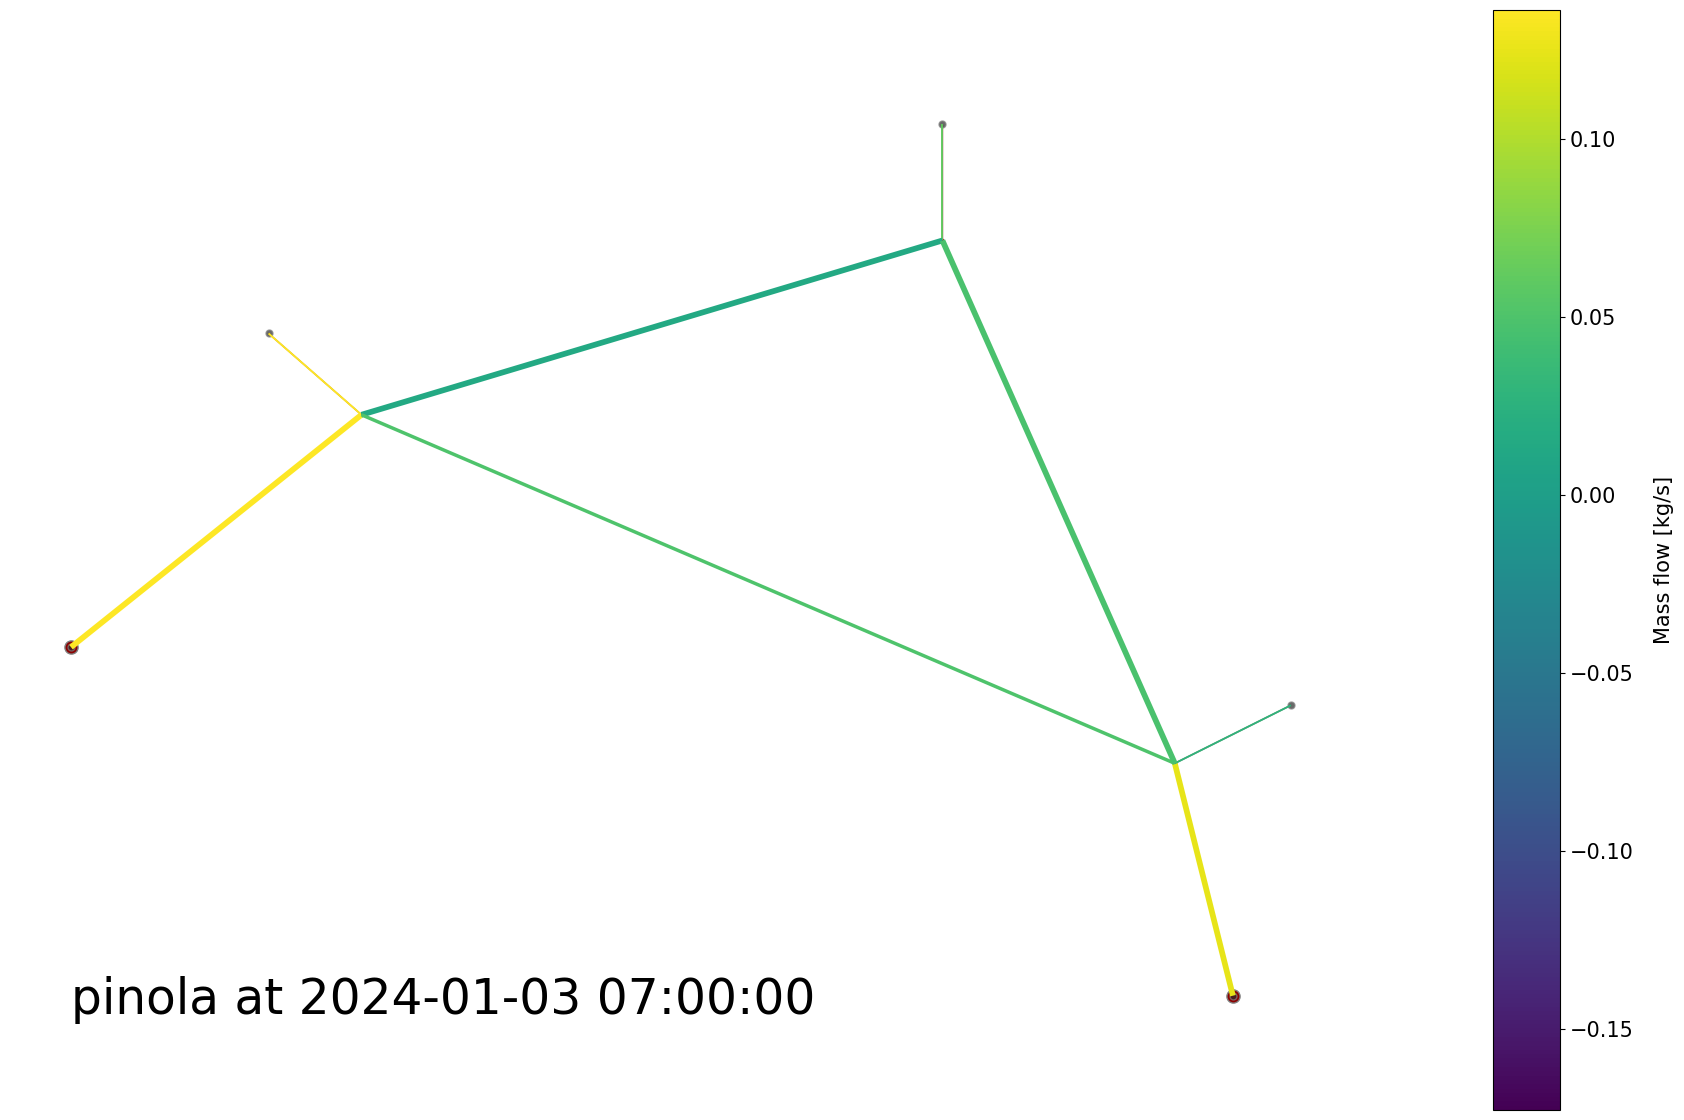

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Selected timestamp: 2024-01-03 20:00:00
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\Visuals_20250409_163822.log


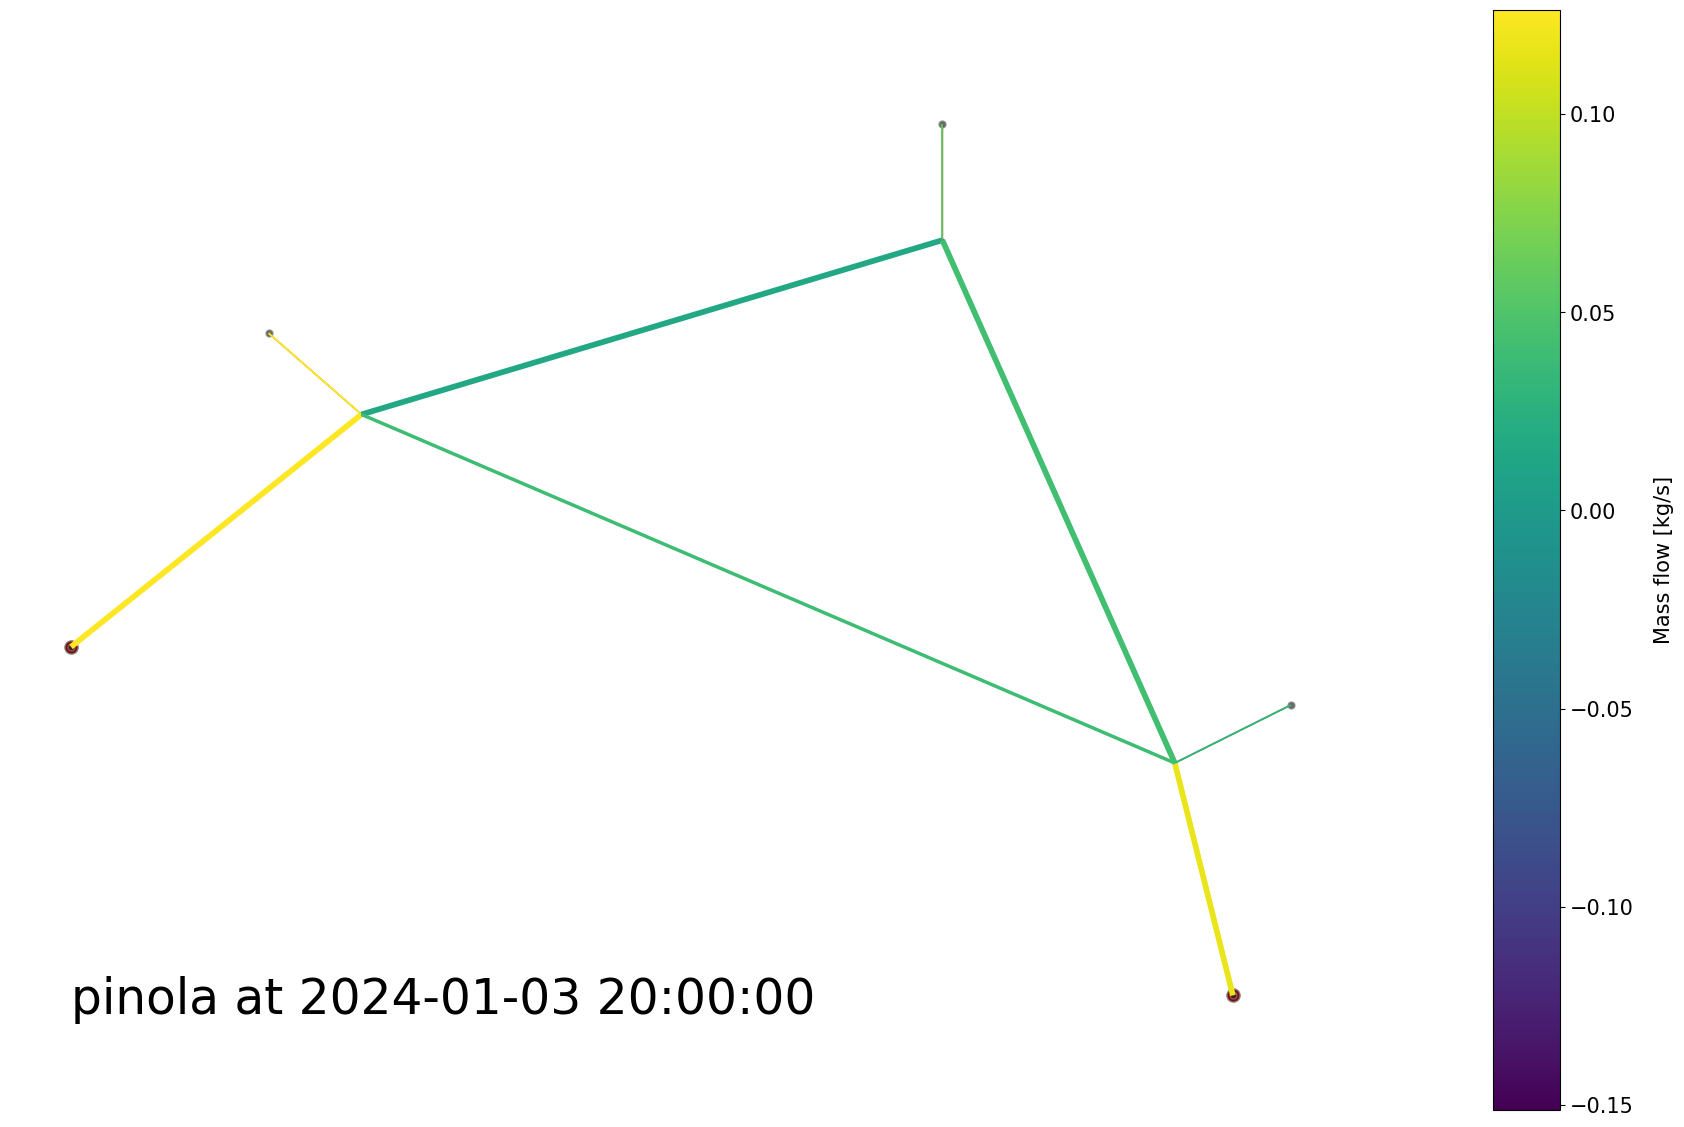

In [110]:
import ipywidgets as widgets
from IPython.display import display

# Create widget layout for better appearance
button_layout = widgets.Layout(width='200px', margin='10px 0px 10px 0px')
checkbox_layout = widgets.Layout(margin='10px 0px 10px 20px')

# Initialize the time selector widget
if selection["is_timeseries"]:
    # Create the time series selector widget (using your existing function)
    time_widget, get_timestamp = create_timeseries_selector(
        graph, get_selection, timeseries_analysis
    )
    
    # Create the update button
    update_button = widgets.Button(
        description="Update Plot",
        button_style='primary',
        tooltip='Click to update the visualization',
        layout=button_layout
    )
    
    # Create a save checkbox
    save_checkbox = widgets.Checkbox(
        value=False,
        description='Save plot to file',
        disabled=False,
        indent=False,
        layout=checkbox_layout
    )
    
    # Optional: Add a text field for custom filename
    filename_input = widgets.Text(
        value='network_plot',
        placeholder='Enter filename (without extension)',
        description='Filename:',
        disabled=False
    )
    
    # Define the update function
    def update_plot_on_click(b):
        """
        Update visualization when the button is clicked.
        Retrieves current timestamp from widget and creates a new plot.
        Saves the plot if the save checkbox is selected.
        """
        # Get current timestamp from widget
        timestamp = get_timestamp()
        selection.update({"timestamp": timestamp})
        
        print(f"Selected timestamp: {timestamp}")
        
        # Determine save path if saving is enabled
        save_path = None
        if save_checkbox.value:
            save_filename = f"{filename_input.value}.png"
            save_path = os.path.join(workspace, save_filename)
            print(f"Plot will be saved to: {save_path}")
        
        # Update graph based on selection type
        if selection["type"] == "edge":
            for edge in list(graph.edges):
                graph.edges[edge]["to_plot"] = graph.edges[edge][selection["attribute"]][timestamp]
            vis = ug.Visuals(graph)
            vis.show_network(
                show_plot=True,
                scaling_factor=1,
                scaling_factor_diameter=50,
                label_size=15,
                ylabel="Mass flow [kg/s]",
                generic_extensive_size="to_plot",
                save_as=save_path,  # Will be None if checkbox is not checked
                timestamp=f"{graph.graph['name']} at {timestamp}"
            )
        elif selection["type"] == "node":
            for node in list(graph.nodes):
                graph.nodes[node]["to_plot"] = graph.nodes[node][selection["attribute"]][timestamp]
            vis = ug.Visuals(graph)
            vis.show_network(
                show_plot=True,
                scaling_factor=1,
                scaling_factor_diameter=50,
                label_size=15,
                generic_extensive_size="to_plot",
                save_as=save_path,  # Will be None if checkbox is not checked
                timestamp=f"{graph.graph['name']} at {timestamp}"
            )
    
    # Connect the button click to the update function
    update_button.on_click(update_plot_on_click)
    
    # Show filename input only when save is checked
    def toggle_filename_visibility(change):
        """Show or hide filename input based on checkbox state"""
        filename_input.layout.display = 'block' if change['new'] else 'none'
    
    save_checkbox.observe(toggle_filename_visibility, names='value')
    
    # Initially hide the filename input if checkbox is unchecked
    filename_input.layout.display = 'none' if not save_checkbox.value else 'block'
    
    # Create a container for all widgets
    controls = widgets.VBox([
        time_widget,
        widgets.HBox([update_button, save_checkbox]),
        filename_input
    ])
    
    # Display the widget container
    display(controls)

Selected timestamp: 2024-01-01 00:00:00
Logfile findable here: C:\Users\rka-lko\AppData\Local\Temp\Visuals_20250409_162923.log


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


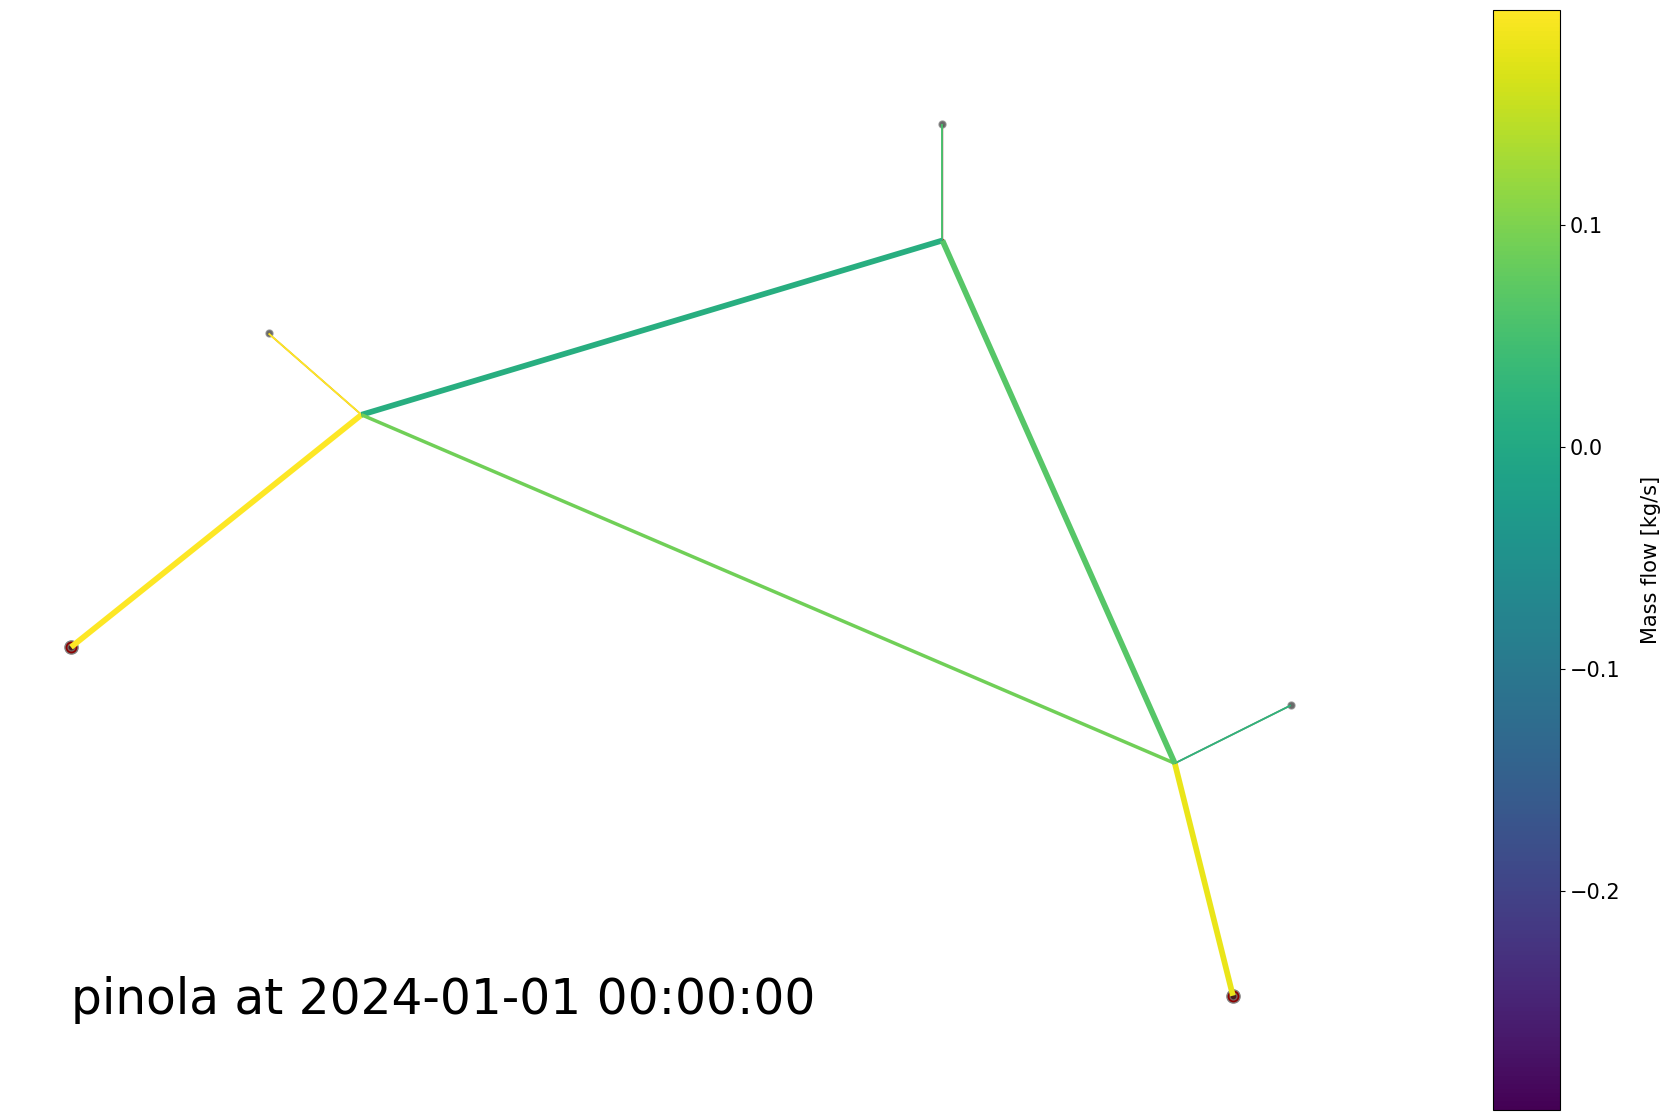

In [106]:
timestamp = None
if selection["is_timeseries"]:
    # Create the time series selector widget
    time_widget, get_timestamp = create_enhanced_timeseries_selector(
        graph, get_selection, timeseries_analysis
    )
    display(time_widget)
    timestamp = get_timestamp()
    selection.update({"timestamp": timestamp})

if timestamp:
    print(f"Selected timestamp: {selection['timestamp']}")
    if selection["type"] == "edge":
        for edge in list(graph.edges):
            graph.edges[edge]["to_plot"] = graph.edges[edge][selection["attribute"]][selection["timestamp"]]
        vis = ug.Visuals(graph)
        vis.show_network(show_plot=True,
                           scaling_factor=1,
                           scaling_factor_diameter=50,
                           label_size=15,
                           ylabel="Mass flow [kg/s]",
                           generic_extensive_size="to_plot",
                           #save_as=os.path.join(workspace, "m_flow.png"),
                           timestamp=f"{graph.graph["name"]} at {selection["timestamp"]}"
                           )
    elif selection["type"] == "node":
        for node in list(graph.nodes):
            graph.nodes[node]["to_plot"] = graph.nodes[node][selection["attribute"]][selection["timestamp"]]
        vis = ug.Visuals(graph)
        vis.show_network(show_plot=True,
                           scaling_factor=1,
                           scaling_factor_diameter=50,
                           label_size=15,
                          # ylabel=f"{NODE_ATTRIBUTES[]"Mass flow [kg/s]",
                           generic_extensive_size="to_plot",
                           #save_as=os.path.join(workspace, "m_flow.png"),
                           timestamp=f"{graph.graph["name"]} at {selection["timestamp"]}"
                           )

In [115]:
time_widget, get_timestamp = create_enhanced_timeseries_selector(
    graph, get_selection, timeseries_analysis
)
display(time_widget)

In [114]:
def create_enhanced_timeseries_selector(graph, selection_function, timeseries_analysis, workspace="./output"):
    """
    Creates an enhanced widget for selecting time points and visualization parameters.
    Extends the base time series selector with parameter tuning and batch processing capabilities.
    
    Parameters:
        graph (NetworkX Graph): The graph object containing the network data
        selection_function (function): Function that returns the current attribute selection
        timeseries_analysis (dict): Analysis of time series data in the graph
        workspace (str): Default workspace directory for saving outputs
        
    Returns:
        tuple: Contains:
            - widget (ipywidget): The enhanced time series selection widget
            - function: A function that returns the selected timestamp when called
    """
    import os
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    from datetime import datetime
    
    # Create the base time selector widget first
    base_widget, get_timestamp = create_timeseries_selector(graph, selection_function, timeseries_analysis)
    
    # Create parameter tuning widgets
    scaling_factor_widget = widgets.FloatSlider(
        value=1.0,
        min=0.1,
        max=5.0,
        step=0.1,
        description='Scale:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )
    
    scaling_diameter_widget = widgets.IntSlider(
        value=50,
        min=10,
        max=100,
        step=5,
        description='Diam Scale:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True
    )
    
    label_size_widget = widgets.IntSlider(
        value=15,
        min=8,
        max=25,
        step=1,
        description='Label Size:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True
    )
    
    # Create dedicated output area for visualization
    output_area = widgets.Output()
    
    # Save options for single visualization
    save_checkbox = widgets.Checkbox(
        value=False,
        description='Save plot',
        disabled=False,
        indent=False
    )
    
    filename_input = widgets.Text(
        value='network_plot',
        placeholder='Enter filename (without extension)',
        description='Filename:',
        disabled=False
    )
    
    # Create update button with prominent styling
    update_button = widgets.Button(
        description='Update Plot',
        disabled=False,
        button_style='primary',
        tooltip='Update the visualization with current settings'
    )
    
    # Get all timestamps from the timeseries analysis
    def get_all_timestamps():
        """Extract all timestamps from the timeseries data"""
        # Try to find an example time series to get all timestamps
        example_series = None
        
        # Look for an example in edge attributes first
        for attr_key, info in timeseries_analysis['edge'].items():
            if info['example_series'] is not None:
                example_series = info['example_series']
                break
        
        # If not found, look in node attributes
        if example_series is None:
            for attr_key, info in timeseries_analysis['node'].items():
                if info['example_series'] is not None:
                    example_series = info['example_series']
                    break
        
        # Extract timestamps if we found an example
        all_timestamps = []
        if example_series is not None and hasattr(example_series, 'index'):
            all_timestamps = example_series.index.tolist()
            
        return all_timestamps
    
    # Batch processing widgets
    all_timestamps = get_all_timestamps()
    timestamp_options = [(ts.strftime('%Y-%m-%d %H:%M:%S'), ts) for ts in all_timestamps]
    
    start_time_dropdown = widgets.Dropdown(
        options=timestamp_options if timestamp_options else [('No timestamps available', None)],
        description='Start time:',
        disabled=True if not timestamp_options else False
    )
    
    end_time_dropdown = widgets.Dropdown(
        options=timestamp_options if timestamp_options else [('No timestamps available', None)],
        description='End time:',
        disabled=True if not timestamp_options else False
    )
    
    # Set default values to first and last if available
    if timestamp_options:
        start_time_dropdown.value = timestamp_options[0][1]
        end_time_dropdown.value = timestamp_options[-1][1]
    
    # Output directory selection with widget-based approach
    output_dir_widget = widgets.Text(
        value=workspace,
        description='Output dir:',
        placeholder='Enter path to save batch results'
    )
    
    # Verify/create directory button
    verify_dir_button = widgets.Button(
        description="Verify/Create Directory",
        tooltip="Check if directory exists and create it if necessary"
    )
    
    # Directory status indicator
    dir_status = widgets.HTML(
        value="<i>Directory status will appear here</i>"
    )
    
    # Batch file prefix
    batch_prefix = widgets.Text(
        value='plot_',
        description='File prefix:',
        placeholder='Prefix for batch filenames'
    )
    
    # Start batch processing button
    batch_button = widgets.Button(
        description='Start Batch Processing',
        disabled=False,
        button_style='danger',
        tooltip='Process and save plots for all timestamps in the selected range'
    )
    
    # Batch progress indicator
    batch_progress = widgets.IntProgress(
        value=0,
        min=0,
        max=100,
        description='Progress:',
        bar_style='',  # 'success', 'info', 'warning', 'danger' or ''
        orientation='horizontal'
    )
    
    batch_status = widgets.HTML(
        value="<i>Batch status will appear here</i>"
    )
    
    # Function to verify/create output directory
    def verify_directory(b=None):
        """Verify if directory exists and create it if necessary"""
        path = output_dir_widget.value
        try:
            if not os.path.exists(path):
                os.makedirs(path)
                dir_status.value = f"<span style='color:green'>Created directory: {path}</span>"
            else:
                dir_status.value = f"<span style='color:green'>Directory exists: {path}</span>"
            return True
        except Exception as e:
            dir_status.value = f"<span style='color:red'>Error: {str(e)}</span>"
            return False
    
    # Register verify directory button handler
    verify_dir_button.on_click(verify_directory)
    
    # Function to create a single visualization
    def create_visualization(b=None):
        """Create and display a visualization with current settings"""
        # Clear previous output
        with output_area:
            clear_output(wait=True)
        
        # Get current settings
        timestamp = get_timestamp()
        if timestamp is None:
            with output_area:
                print("No valid timestamp selected")
            return
        
        # Get current selection
        selection = selection_function()
        selection.update({"timestamp": timestamp})
        
        # Determine if we should save the plot
        save_path = None
        if save_checkbox.value:
            filename = f"{filename_input.value}.png"
            save_path = os.path.join(workspace, filename)
        
        # Display the plot in the output area
        with output_area:
            # Get current parameter values
            scaling_factor = scaling_factor_widget.value
            scaling_factor_diameter = scaling_diameter_widget.value
            label_size = label_size_widget.value
            
            try:
                # Update the graph based on selection type
                if selection["type"] == "edge":
                    for edge in list(graph.edges):
                        graph.edges[edge]["to_plot"] = graph.edges[edge][selection["attribute"]][timestamp]
                elif selection["type"] == "node":
                    for node in list(graph.nodes):
                        graph.nodes[node]["to_plot"] = graph.nodes[node][selection["attribute"]][timestamp]
                
                # Create visualization
                vis = ug.Visuals(graph)
                vis.show_network(
                    show_plot=True,
                    scaling_factor=scaling_factor,
                    scaling_factor_diameter=scaling_factor_diameter,
                    label_size=label_size,
                    generic_extensive_size="to_plot",
                    save_as=save_path,
                    timestamp=f"{graph.graph['name']} at {selection['timestamp']}"
                )
                
                if save_path:
                    print(f"Plot saved to: {save_path}")
            except Exception as e:
                print(f"Error creating visualization: {str(e)}")
    
    # Register update button handler
    update_button.on_click(create_visualization)
    
    # Function to perform batch processing
    def start_batch_processing(b=None):
        """Process all timestamps in the selected range and save plots"""
        # Verify directory first
        if not verify_directory():
            return
        
        # Get current selection
        selection = selection_function()
        
        # Get all timestamps between start and end
        start_time = start_time_dropdown.value
        end_time = end_time_dropdown.value
        
        if start_time is None or end_time is None:
            with output_area:
                clear_output(wait=True)
                print("Invalid time range selected")
            return
        
        # Ensure start is before end
        if start_time > end_time:
            start_time, end_time = end_time, start_time
        
        # Get the timestamps to process
        timestamps_to_process = [ts for ts in all_timestamps if start_time <= ts <= end_time]
        
        # Update progress indicator
        batch_progress.max = len(timestamps_to_process)
        batch_progress.value = 0
        
        # Start processing
        batch_status.value = "<span style='color:blue'>Batch processing started...</span>"
        
        # Process each timestamp
        output_dir = output_dir_widget.value
        prefix = batch_prefix.value
        
        with output_area:
            clear_output(wait=True)
            print(f"Starting batch processing of {len(timestamps_to_process)} timestamps...")
            print(f"Output directory: {output_dir}")
            
            try:
                for i, timestamp in enumerate(timestamps_to_process):
                    # Update progress
                    batch_progress.value = i + 1
                    batch_status.value = f"<span style='color:blue'>Processing {i+1}/{len(timestamps_to_process)}: {timestamp.strftime('%Y-%m-%d %H:%M:%S')}</span>"
                    
                    # Update selection with current timestamp
                    selection.update({"timestamp": timestamp})
                    
                    # Format timestamp for filename
                    timestamp_str = timestamp.strftime('%Y%m%d_%H%M%S')
                    filename = f"{prefix}{selection['type']}_{selection['attribute']}_{timestamp_str}.png"
                    save_path = os.path.join(output_dir, filename)
                    
                    # Update the graph based on selection type
                    if selection["type"] == "edge":
                        for edge in list(graph.edges):
                            graph.edges[edge]["to_plot"] = graph.edges[edge][selection["attribute"]][timestamp]
                    elif selection["type"] == "node":
                        for node in list(graph.nodes):
                            graph.nodes[node]["to_plot"] = graph.nodes[node][selection["attribute"]][timestamp]
                    
                    # Create visualization (without showing in notebook)
                    vis = ug.Visuals(graph)
                    vis.show_network(
                        show_plot=False,  # Don't show in notebook during batch processing
                        scaling_factor=scaling_factor_widget.value,
                        scaling_factor_diameter=scaling_diameter_widget.value,
                        label_size=label_size_widget.value,
                        generic_extensive_size="to_plot",
                        save_as=save_path,
                        timestamp=f"{graph.graph['name']} at {selection['timestamp']}"
                    )
                    
                    print(f"Saved: {filename}")
                
                print("Batch processing complete!")
                batch_status.value = f"<span style='color:green'>Batch processing complete! {len(timestamps_to_process)} files saved to {output_dir}</span>"
            
            except Exception as e:
                print(f"Error during batch processing: {str(e)}")
                batch_status.value = f"<span style='color:red'>Error during batch processing: {str(e)}</span>"
    
    # Register batch button handler
    batch_button.on_click(start_batch_processing)
    
    # Create the single visualization tab
    single_tab = widgets.VBox([
        widgets.HTML("<h3>Visualization Parameters</h3>"),
        widgets.HBox([scaling_factor_widget, scaling_diameter_widget]),
        widgets.HBox([label_size_widget, update_button]),
        widgets.HBox([save_checkbox, filename_input]),
        widgets.HTML("<h4>Visualization Output</h4>"),
        output_area
    ])
    
    # Create the batch processing tab
    batch_tab = widgets.VBox([
        widgets.HTML("<h3>Batch Processing</h3>"),
        widgets.HBox([start_time_dropdown, end_time_dropdown]),
        widgets.HBox([output_dir_widget, verify_dir_button]),
        dir_status,
        widgets.HBox([batch_prefix, batch_button]),
        batch_progress,
        batch_status,
        widgets.HTML("<i>Note: Batch processing uses visualization parameters from the 'Single Plot' tab</i>")
    ])
    
    # Create tabs
    tabs = widgets.Tab()
    tabs.children = [single_tab, batch_tab]
    tabs.set_title(0, 'Single Plot')
    tabs.set_title(1, 'Batch Processing')
    
    # Final widget layout
    final_widget = widgets.VBox([
        base_widget,
        tabs
    ])
    
    # Return the final widget and the timestamp getter function
    return final_widget, get_timestamp

In [90]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime


def create_attribute_selector(graph, edge_attributes, node_attributes):
    """
    Creates a widget for selecting graph attributes with enhanced display options
    and attribute validation.
    
    Parameters:
        graph (NetworkX Graph): The graph object containing the network data
        edge_attributes (dict): Dictionary containing edge attribute metadata
        node_attributes (dict): Dictionary containing node attribute metadata
        
    Returns:
        tuple: Contains:
            - widget (ipywidget): The attribute selection widget
            - function: A function that returns the current selection when called
    """
    # Analyze graph to identify actual attributes present
    def analyze_graph_attributes():
        """
        Analyzes the graph to identify which attributes are actually present in the data
        and compares them against the expected attributes from the schema.
        
        Returns:
            dict: Contains information about actual, missing, and unexpected attributes
        """
        # Collect actual edge attributes from graph
        actual_edge_attrs = set()
        for u, v, data in graph.edges(data=True):
            actual_edge_attrs.update(data.keys())
        
        # Collect actual node attributes from graph
        actual_node_attrs = set()
        for node, data in graph.nodes(data=True):
            actual_node_attrs.update(data.keys())
        
        # Get expected attributes from schema
        expected_edge_attrs = set(edge_attributes.keys())
        expected_node_attrs = set(node_attributes.keys())
        
        # Calculate missing and unexpected attributes
        missing_edge_attrs = expected_edge_attrs - actual_edge_attrs
        unexpected_edge_attrs = actual_edge_attrs - expected_edge_attrs
        
        missing_node_attrs = expected_node_attrs - actual_node_attrs
        unexpected_node_attrs = actual_node_attrs - expected_node_attrs
        
        return {
            'edge': {
                'actual': actual_edge_attrs,
                'expected': expected_edge_attrs,
                'missing': missing_edge_attrs,
                'unexpected': unexpected_edge_attrs
            },
            'node': {
                'actual': actual_node_attrs,
                'expected': expected_node_attrs,
                'missing': missing_node_attrs,
                'unexpected': unexpected_node_attrs
            }
        }
    
    # Analyze time series data in the graph - this will be used by both widgets
    def analyze_timeseries_data():
        """
        Analyzes time series data in the graph to determine time ranges,
        frequencies, and other time-related metadata.
        
        Returns:
            dict: Contains information about time series data
        """
        # Initialize data structures for time series analysis
        timeseries_info = {
            'edge': {},
            'node': {}
        }
        
        # Find all time series attributes in the edge data
        for attr_key, attr_info in edge_attributes.items():
            if attr_info.get('is_timeseries', False):
                timeseries_info['edge'][attr_key] = {
                    'min_time': None,
                    'max_time': None,
                    'frequency': None,
                    'example_series': None,
                    'count': 0
                }
        
        # Find all time series attributes in the node data
        for attr_key, attr_info in node_attributes.items():
            if attr_info.get('is_timeseries', False):
                timeseries_info['node'][attr_key] = {
                    'min_time': None,
                    'max_time': None,
                    'frequency': None,
                    'example_series': None,
                    'count': 0
                }
        
        # Analyze edge time series data
        for u, v, data in graph.edges(data=True):
            for attr_key in timeseries_info['edge'].keys():
                if attr_key in data:
                    ts_data = data[attr_key]
                    info = timeseries_info['edge'][attr_key]
                    
                    # Update count of instances
                    info['count'] += 1
                    
                    # Store example time series for reference
                    if info['example_series'] is None:
                        info['example_series'] = ts_data
                    
                    # Extract time information if it's a pandas Series with DatetimeIndex
                    if hasattr(ts_data, 'index') and hasattr(ts_data.index, 'min'):
                        try:
                            min_time = ts_data.index.min()
                            max_time = ts_data.index.max()
                            
                            # Update global min/max
                            if info['min_time'] is None or min_time < info['min_time']:
                                info['min_time'] = min_time
                            
                            if info['max_time'] is None or max_time > info['max_time']:
                                info['max_time'] = max_time
                            
                            # Try to determine frequency if not already set
                            if info['frequency'] is None and hasattr(ts_data.index, 'freq'):
                                info['frequency'] = ts_data.index.freq
                        except (AttributeError, TypeError):
                            pass
        
        # Analyze node time series data
        for node, data in graph.nodes(data=True):
            for attr_key in timeseries_info['node'].keys():
                if attr_key in data:
                    ts_data = data[attr_key]
                    info = timeseries_info['node'][attr_key]
                    
                    # Update count of instances
                    info['count'] += 1
                    
                    # Store example time series for reference
                    if info['example_series'] is None:
                        info['example_series'] = ts_data
                    
                    # Extract time information if it's a pandas Series with DatetimeIndex
                    if hasattr(ts_data, 'index') and hasattr(ts_data.index, 'min'):
                        try:
                            min_time = ts_data.index.min()
                            max_time = ts_data.index.max()
                            
                            # Update global min/max
                            if info['min_time'] is None or min_time < info['min_time']:
                                info['min_time'] = min_time
                            
                            if info['max_time'] is None or max_time > info['max_time']:
                                info['max_time'] = max_time
                            
                            # Try to determine frequency if not already set
                            if info['frequency'] is None and hasattr(ts_data.index, 'freq'):
                                info['frequency'] = ts_data.index.freq
                        except (AttributeError, TypeError):
                            pass
        
        # Find global min and max times across all time series for convenience
        global_min_time = None
        global_max_time = None
        
        for attr_type in ['edge', 'node']:
            for attr_key, info in timeseries_info[attr_type].items():
                if info['min_time'] is not None:
                    if global_min_time is None or info['min_time'] < global_min_time:
                        global_min_time = info['min_time']
                
                if info['max_time'] is not None:
                    if global_max_time is None or info['max_time'] > global_max_time:
                        global_max_time = info['max_time']
        
        # Add global time range information
        timeseries_info['global'] = {
            'min_time': global_min_time,
            'max_time': global_max_time
        }
        
        return timeseries_info
    
    # Run attribute analysis
    attribute_analysis = analyze_graph_attributes()
    
    # Run time series analysis
    timeseries_analysis = analyze_timeseries_data()
    
    # Function to format attribute options with clear names
    def format_attribute_options(attributes_dict, actual_attrs, unexpected_attrs, is_timeseries_only=True):
        """
        Formats attribute options for dropdown menus, adding indicators for attributes
        that are actually present in the graph and handling unexpected attributes.
        
        Parameters:
            attributes_dict (dict): Dictionary of expected attributes and their metadata
            actual_attrs (set): Set of attributes actually present in the graph
            unexpected_attrs (set): Set of attributes found in graph but not in schema
            is_timeseries_only (bool): Whether to filter for timeseries attributes only
            
        Returns:
            list: Formatted list of (display_name, attribute_key) tuples for dropdown
        """
        options = []
        
        # Add expected attributes from the schema
        for attr_key, attr_info in attributes_dict.items():
            # Skip if we're filtering for timeseries and this isn't one
            if is_timeseries_only and not attr_info.get("is_timeseries", False):
                continue
            
            # Use the "name" field if available, otherwise use the attribute key
            display_name = attr_info.get("name", attr_key)
            
            # Add indicator if attribute is actually present in graph
            if attr_key in actual_attrs:
                display_name = "✓ " + display_name
            else:
                display_name = "✗ " + display_name
                
            options.append((display_name, attr_key))
        
        # Add unexpected attributes (those present in graph but not in schema)
        for attr_key in sorted(unexpected_attrs):
            display_name = "! " + attr_key + " (undefined)"
            options.append((display_name, attr_key))
        
        return options
    
    # Create visualization type selector
    vis_type = widgets.RadioButtons(
        options=[('Edge-based', 'edge'), ('Node-based', 'node')],
        description='Visualization type:',
        disabled=False
    )
    
    # Create timeseries filter checkbox
    timeseries_only = widgets.Checkbox(
        value=True,
        description='Timeseries only',
        disabled=False
    )
    
    # Create attribute dropdowns (initially with edge attributes)
    edge_dropdown = widgets.Dropdown(
        options=format_attribute_options(
            edge_attributes, 
            attribute_analysis['edge']['actual'],
            attribute_analysis['edge']['unexpected'],
            is_timeseries_only=True
        ),
        description='Edge attribute:',
        disabled=False
    )
    
    node_dropdown = widgets.Dropdown(
        options=format_attribute_options(
            node_attributes, 
            attribute_analysis['node']['actual'],
            attribute_analysis['node']['unexpected'],
            is_timeseries_only=True
        ),
        description='Node attribute:',
        disabled=True
    )
    
    # Display information about the selected attribute
    attribute_info = widgets.HTML(
        value="<i>Select an attribute to see details</i>"
    )
    
    # Create attribute status widget
    attribute_status = widgets.HTML(
        value="<i>Loading attribute status...</i>"
    )
    
    # Function to update dropdown options based on timeseries filter
    def update_dropdown_options(change=None):
        """
        Updates dropdown options based on the timeseries filter state.
        """
        is_timeseries_only = timeseries_only.value
        
        # Update edge dropdown options
        edge_dropdown.options = format_attribute_options(
            edge_attributes, 
            attribute_analysis['edge']['actual'],
            attribute_analysis['edge']['unexpected'],
            is_timeseries_only=is_timeseries_only
        )
        
        # Update node dropdown options
        node_dropdown.options = format_attribute_options(
            node_attributes, 
            attribute_analysis['node']['actual'],
            attribute_analysis['node']['unexpected'],
            is_timeseries_only=is_timeseries_only
        )
    
    # Toggle between edge and node dropdowns
    def on_vis_type_change(change):
        """
        Updates the UI when the visualization type (edge/node) changes.
        """
        if change['new'] == 'edge':
            edge_dropdown.disabled = False
            node_dropdown.disabled = True
            update_attribute_status('edge')
            update_attribute_info()
        else:
            edge_dropdown.disabled = True
            node_dropdown.disabled = False
            update_attribute_status('node')
            update_attribute_info()
    
    # Register observers
    vis_type.observe(on_vis_type_change, names='value')
    timeseries_only.observe(update_dropdown_options, names='value')
    
    # Update attribute status information
    def update_attribute_status(attr_type='edge'):
        """
        Updates the attribute status display showing statistics about
        known vs. unexpected attributes in the graph.
        
        Parameters:
            attr_type (str): Either 'edge' or 'node'
        """
        analysis = attribute_analysis[attr_type]
        
        # Generate HTML for attribute status
        status_html = f"<h4>{attr_type.capitalize()} Attribute Status:</h4>"
        
        # Create a table showing attribute statistics
        status_html += "<table style='width:100%; border-collapse: collapse;'>"
        status_html += "<tr style='background-color:#f0f0f0'><th style='text-align:left; padding:5px;'>Category</th><th style='text-align:right; padding:5px;'>Count</th></tr>"
        
        # Table rows with counts
        status_html += f"<tr><td style='padding:5px;'>Expected (in schema)</td><td style='text-align:right; padding:5px;'>{len(analysis['expected'])}</td></tr>"
        status_html += f"<tr><td style='padding:5px;'>Actually present in graph</td><td style='text-align:right; padding:5px;'>{len(analysis['actual'])}</td></tr>"
        status_html += f"<tr><td style='padding:5px;'>Missing (in schema but not in graph)</td><td style='text-align:right; padding:5px;'>{len(analysis['missing'])}</td></tr>"
        status_html += f"<tr><td style='padding:5px;'>Unexpected (in graph but not in schema)</td><td style='text-align:right; padding:5px;'>{len(analysis['unexpected'])}</td></tr>"
        status_html += "</table>"
        
        # Add legend
        status_html += "<p><small><b>Legend:</b> ✓ = present in graph, ✗ = not present in graph, ! = unexpected (not in schema)</small></p>"
        
        # List unexpected attributes if any exist
        if analysis['unexpected']:
            status_html += "<p><b>Unexpected attributes:</b><br>"
            status_html += ", ".join(sorted(analysis['unexpected']))
            status_html += "</p>"
        
        attribute_status.value = status_html
        
    # Update attribute information when selection changes
    def update_attribute_info(change=None):
        """
        Updates the displayed information about the currently selected attribute.
        """
        if vis_type.value == 'edge':
            selected_attr = edge_dropdown.value
            attr_dict = edge_attributes
            is_unexpected = selected_attr in attribute_analysis['edge']['unexpected']
            attr_type = 'edge'
        else:
            selected_attr = node_dropdown.value
            attr_dict = node_attributes
            is_unexpected = selected_attr in attribute_analysis['node']['unexpected']
            attr_type = 'node'
            
        if not selected_attr:
            attribute_info.value = "<i>Select an attribute to see details</i>"
            return
            
        # For unexpected attributes (not in schema)
        if is_unexpected:
            info_html = f"<b>{selected_attr}</b> (undefined in schema)<br>"
            info_html += "<i>This attribute is present in the graph but not defined in the schema.</i><br>"
            
            # Try to provide some basic statistics about the attribute
            if vis_type.value == 'edge':
                values = [data.get(selected_attr) for _, _, data in graph.edges(data=True) if selected_attr in data]
            else:
                values = [data.get(selected_attr) for _, data in graph.nodes(data=True) if selected_attr in data]
                
            if values:
                # Check if it's a time series
                is_timeseries = False
                example = values[0]
                if hasattr(example, 'index') and hasattr(example.index, 'min'):
                    is_timeseries = True
                    info_html += "<b>This appears to be a time series attribute.</b><br>"
                    
                    # Time range information
                    try:
                        min_time = example.index.min()
                        max_time = example.index.max()
                        info_html += f"Time range: {min_time} to {max_time}<br>"
                        
                        # Number of time points
                        info_html += f"Number of time points: {len(example.index)}<br>"
                        
                        # Frequency if available
                        if hasattr(example.index, 'freq') and example.index.freq:
                            info_html += f"Frequency: {example.index.freq}<br>"
                    except (AttributeError, TypeError):
                        pass
                
                if not is_timeseries:
                    # Basic type information
                    types = set(type(v).__name__ for v in values if v is not None)
                    info_html += f"Data type(s): {', '.join(types)}<br>"
                    
                    # Count of non-None values
                    non_none = sum(1 for v in values if v is not None)
                    info_html += f"Present in {non_none} out of {len(values)} {vis_type.value}s<br>"
                    
                    # For numeric data, show some statistics
                    try:
                        numeric_values = [float(v) for v in values if v is not None]
                        if numeric_values:
                            info_html += f"Min: {min(numeric_values)}, Max: {max(numeric_values)}<br>"
                            info_html += f"Mean: {sum(numeric_values)/len(numeric_values):.2f}<br>"
                    except (ValueError, TypeError):
                        # Not numeric data
                        pass
                    
            attribute_info.value = info_html
            return
            
        # For known attributes (in schema)
        if selected_attr and selected_attr in attr_dict:
            attr_info = attr_dict[selected_attr]
            
            # Build information HTML
            info_html = f"<b>{attr_info.get('name', selected_attr)}</b><br>"
            
            if attr_info.get('description'):
                info_html += f"Description: {attr_info['description']}<br>"
                
            if attr_info.get('unit'):
                info_html += f"Unit: {attr_info['unit']}<br>"
                
            if attr_info.get('is_timeseries'):
                info_html += "<i>This is a timeseries attribute.</i><br>"
                
                # Add time series specific information if available
                if attr_type in timeseries_analysis and selected_attr in timeseries_analysis[attr_type]:
                    ts_info = timeseries_analysis[attr_type][selected_attr]
                    
                    if ts_info['min_time'] and ts_info['max_time']:
                        info_html += f"Time range: {ts_info['min_time']} to {ts_info['max_time']}<br>"
                    
                    if ts_info['frequency']:
                        info_html += f"Frequency: {ts_info['frequency']}<br>"
                    
                    if ts_info['count'] > 0:
                        info_html += f"Present in {ts_info['count']} {attr_type}s<br>"
                        
                    if ts_info['example_series'] is not None:
                        info_html += f"Number of time points: {len(ts_info['example_series'])}<br>"
            else:
                info_html += "<i>This is a static attribute (not a timeseries).</i><br>"
                
            # Add presence information
            if vis_type.value == 'edge':
                is_present = selected_attr in attribute_analysis['edge']['actual']
            else:
                is_present = selected_attr in attribute_analysis['node']['actual']
                
            if is_present:
                info_html += "<span style='color:green'>✓ This attribute is present in the graph data.</span>"
            else:
                info_html += "<span style='color:red'>✗ This attribute is defined in the schema but not present in the graph data.</span>"
                
            attribute_info.value = info_html
    
    # Register attribute change observers
    edge_dropdown.observe(update_attribute_info, names='value')
    node_dropdown.observe(update_attribute_info, names='value')
    vis_type.observe(update_attribute_info, names='value')
    
    # Initial updates
    update_attribute_status('edge')
    update_attribute_info()
    
    # Create attribute tables for a more detailed view
    def create_attribute_table():
        """
        Creates a more detailed table view of all attributes with their status.
        """
        # Create tabs for edge and node attributes
        tab = widgets.Tab()
        
        # Function to create a DataFrame for attributes
        def create_attr_dataframe(attr_type):
            """Creates a DataFrame showing all attributes with their status"""
            analysis = attribute_analysis[attr_type]
            attr_dict = edge_attributes if attr_type == 'edge' else node_attributes
            
            # Combine all attributes
            all_attrs = sorted(analysis['expected'] | analysis['unexpected'])
            
            # Create data for DataFrame
            data = []
            for attr in all_attrs:
                is_in_schema = attr in attr_dict
                is_in_graph = attr in analysis['actual']
                
                if is_in_schema:
                    attr_info = attr_dict[attr]
                    name = attr_info.get('name', attr)
                    is_timeseries = attr_info.get('is_timeseries', False)
                    unit = attr_info.get('unit', '')
                    description = attr_info.get('description', '')
                else:
                    name = attr + " (undefined)"
                    is_timeseries = "Unknown"
                    unit = "Unknown"
                    description = "This attribute is not defined in the schema"
                
                # Add time series info if available
                if is_timeseries and attr_type in timeseries_analysis and attr in timeseries_analysis[attr_type]:
                    ts_info = timeseries_analysis[attr_type][attr]
                    time_range = f"{ts_info['min_time']} to {ts_info['max_time']}" if ts_info['min_time'] and ts_info['max_time'] else "Unknown"
                else:
                    time_range = "N/A"
                
                data.append({
                    'Attribute Key': attr,
                    'Display Name': name,
                    'In Schema': is_in_schema,
                    'In Graph': is_in_graph,
                    'Timeseries': is_timeseries,
                    'Time Range': time_range,
                    'Unit': unit,
                    'Description': description
                })
            
            return pd.DataFrame(data)
        
        # Create DataFrame output widgets
        edge_output = widgets.Output()
        node_output = widgets.Output()
        
        with edge_output:
            edge_df = create_attr_dataframe('edge')
            display(edge_df)
            
        with node_output:
            node_df = create_attr_dataframe('node')
            display(node_df)
        
        # Set tab children and titles
        tab.children = [edge_output, node_output]
        tab.set_title(0, 'Edge Attributes')
        tab.set_title(1, 'Node Attributes')
        
        return tab
    
    # Create the detail table widget
    attribute_table = create_attribute_table()
    
    # Detail toggle button
    detail_button = widgets.ToggleButton(
        value=False,
        description='Show detailed attribute tables',
        disabled=False,
        button_style='',
        tooltip='Display detailed tables of all attributes'
    )
    
    # Detail output container
    detail_output = widgets.Output()
    
    # Toggle function for detail view
    def on_detail_toggle(change):
        """Toggles the display of the detailed attribute tables"""
        detail_output.clear_output()
        if change['new']:
            with detail_output:
                display(attribute_table)
    
    # Register detail toggle observer
    detail_button.observe(on_detail_toggle, names='value')
    
    # Layout the attribute selector widget
    widget = widgets.VBox([
        widgets.HTML("<h3>Graph Attribute Selection</h3>"),
        widgets.HBox([vis_type, timeseries_only]),
        widgets.HBox([edge_dropdown, node_dropdown]),
        attribute_info,
        widgets.HTML("<h3>Attribute Schema Validation</h3>"),
        attribute_status,
        detail_button,
        detail_output
    ])
    
    # Function to retrieve the current selection
    def get_selection():
        """
        Returns the current visualization type, selected attribute, and time point
        
        Returns:
            dict: Contains 'type' (edge/node), 'attribute' (selected attribute key),
                  and metadata about the selected attribute
        """
        if vis_type.value == 'edge':
            attr_key = edge_dropdown.value
            is_unexpected = attr_key in attribute_analysis['edge']['unexpected']
            
            result = {
                'type': 'edge', 
                'attribute': attr_key,
                'is_in_schema': not is_unexpected,
                'is_in_graph': attr_key in attribute_analysis['edge']['actual']
            }
            
            # Add time series info
            if not is_unexpected and attr_key in edge_attributes:
                result['is_timeseries'] = edge_attributes[attr_key].get('is_timeseries', False)
            else:
                # For unexpected attributes, try to determine if it's a time series
                for u, v, data in graph.edges(data=True):
                    if attr_key in data:
                        example = data[attr_key]
                        if hasattr(example, 'index') and hasattr(example.index, 'min'):
                            result['is_timeseries'] = True
                        else:
                            result['is_timeseries'] = False
                        break
                else:
                    result['is_timeseries'] = False
                    
        else:  # Node attribute
            attr_key = node_dropdown.value
            is_unexpected = attr_key in attribute_analysis['node']['unexpected']
            
            result = {
                'type': 'node', 
                'attribute': attr_key,
                'is_in_schema': not is_unexpected,
                'is_in_graph': attr_key in attribute_analysis['node']['actual']
            }
            
            # Add time series info
            if not is_unexpected and attr_key in node_attributes:
                result['is_timeseries'] = node_attributes[attr_key].get('is_timeseries', False)
            else:
                # For unexpected attributes, try to determine if it's a time series
                for node, data in graph.nodes(data=True):
                    if attr_key in data:
                        example = data[attr_key]
                        if hasattr(example, 'index') and hasattr(example.index, 'min'):
                            result['is_timeseries'] = True
                        else:
                            result['is_timeseries'] = False
                        break
                else:
                    result['is_timeseries'] = False
        
        return result
    
    # Return both the widget and the selection function
    return widget, get_selection, timeseries_analysis


def create_timeseries_selector(graph, selection_function, timeseries_analysis):
    """
    Creates a widget for selecting time points for a time series attribute.
    Takes input from an attribute selection widget to know which time series to display.
    
    Parameters:
        graph (NetworkX Graph): The graph object containing the network data
        selection_function (function): Function that returns the current attribute selection
        timeseries_analysis (dict): Analysis of time series data in the graph
        
    Returns:
        tuple: Contains:
            - widget (ipywidget): The time series selection widget
            - function: A function that returns the selected timestamp when called
    """
    # Create time selection widgets
    # 1. A dropdown for specific time points
    # 2. A slider for continuous time selection
    
    # Get global time range for initial widget setup
    global_min_time = timeseries_analysis['global']['min_time']
    global_max_time = timeseries_analysis['global']['max_time']
    
    # Create a list of all timestamps if we have time series data
    all_timestamps = []
    if global_min_time is not None and global_max_time is not None:
        # Try to find an example time series to get all timestamps
        example_series = None
        
        # Look for an example in edge attributes first
        for attr_key, info in timeseries_analysis['edge'].items():
            if info['example_series'] is not None:
                example_series = info['example_series']
                break
        
        # If not found, look in node attributes
        if example_series is None:
            for attr_key, info in timeseries_analysis['node'].items():
                if info['example_series'] is not None:
                    example_series = info['example_series']
                    break
        
        # Extract timestamps if we found an example
        if example_series is not None and hasattr(example_series, 'index'):
            all_timestamps = example_series.index.tolist()
    
    # Format timestamps for display
    timestamp_options = []
    for ts in all_timestamps:
        timestamp_options.append((ts.strftime('%Y-%m-%d %H:%M:%S'), ts))
    
    # Create time selector dropdown
    time_dropdown = widgets.Dropdown(
        options=timestamp_options if timestamp_options else [('No timestamps available', None)],
        description='Time:',
        disabled=True if not timestamp_options else False
    )
    
    # Create time slider for continuous selection
    time_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(all_timestamps) - 1 if all_timestamps else 0,
        step=1,
        description='Time index:',
        disabled=True if not timestamp_options else False,
        continuous_update=False,
        orientation='horizontal',
        readout=True
    )
    
    # Selected time display
    selected_time_display = widgets.HTML(
        value="<i>Select a time series attribute first</i>" if not timestamp_options else 
              f"<b>Current time:</b> {all_timestamps[0].strftime('%Y-%m-%d %H:%M:%S')}" if all_timestamps else
              "<i>No timestamps available</i>"
    )
    
    # Time series visualization placeholder
    time_visualization = widgets.HTML(
        value="<i>Select a time series attribute to see preview</i>"
    )
    
    # Function to update time selector widgets based on the selected attribute
    def update_time_selectors():
        """
        Updates the time selector widgets based on the current attribute selection.
        """
        # Get current attribute selection
        selection = selection_function()
        
        # Extract relevant information
        attr_type = selection.get('type', 'edge')
        attr_key = selection.get('attribute')
        is_timeseries = selection.get('is_timeseries', False)
        
        if not attr_key or not is_timeseries:
            # Disable time selectors
            time_dropdown.disabled = True
            time_slider.disabled = True
            selected_time_display.value = (
                "<i>Selected attribute is not a time series</i>" if attr_key else
                "<i>Select a time series attribute first</i>"
            )
            return
        
        # Find the specific timestamps for this attribute if possible
        attr_timestamps = all_timestamps  # Default to global timestamps
        
        # Try to get specific timestamps for this attribute
        if attr_type in timeseries_analysis and attr_key in timeseries_analysis[attr_type]:
            info = timeseries_analysis[attr_type][attr_key]
            if info['example_series'] is not None and hasattr(info['example_series'], 'index'):
                attr_timestamps = info['example_series'].index.tolist()
        
        # Update dropdown options
        timestamp_options = []
        for ts in attr_timestamps:
            timestamp_options.append((ts.strftime('%Y-%m-%d %H:%M:%S'), ts))
        
        # Update the dropdown
        time_dropdown.options = timestamp_options if timestamp_options else [('No timestamps available', None)]
        if timestamp_options:
            time_dropdown.value = timestamp_options[0][1]  # Select first timestamp
        
        # Update the slider
        time_slider.max = len(attr_timestamps) - 1 if attr_timestamps else 0
        time_slider.value = 0
        
        # Enable time selectors
        time_dropdown.disabled = False if timestamp_options else True
        time_slider.disabled = False if timestamp_options else True
        
        # Update selected time display
        if attr_timestamps:
            selected_time_display.value = f"<b>Current time:</b> {attr_timestamps[0].strftime('%Y-%m-%d %H:%M:%S')}"
        else:
            selected_time_display.value = "<i>No timestamps available for this attribute</i>"
    
    # Function to keep dropdown and slider in sync
    def sync_time_selectors(change):
        """
        Keeps the time dropdown and slider in sync.
        """
        if change['owner'] == time_slider:
            # Slider was changed, update dropdown
            if time_slider.value < len(time_dropdown.options):
                time_dropdown.value = time_dropdown.options[time_slider.value][1]
        elif change['owner'] == time_dropdown:
            # Dropdown was changed, update slider
            for i, (_, value) in enumerate(time_dropdown.options):
                if value == time_dropdown.value:
                    time_slider.value = i
                    break
        
        # Update selected time display
        if not time_dropdown.disabled and time_dropdown.value is not None:
            selected_time_display.value = f"<b>Current time:</b> {time_dropdown.value.strftime('%Y-%m-%d %H:%M:%S')}"
    
    # Register time selector observers
    time_slider.observe(sync_time_selectors, names='value')
    time_dropdown.observe(sync_time_selectors, names='value')
    
    # Create update button
    update_button = widgets.Button(
        description='Update from Attribute Selection',
        disabled=False,
        button_style='',
        tooltip='Update time selectors based on the current attribute selection'
    )
    
    # Register update button click handler
    update_button.on_click(lambda b: update_time_selectors())
    
    # Layout the time series selector widget
    widget = widgets.VBox([
        widgets.HTML("<h3>Time Series Selection</h3>"),
        update_button,
        widgets.HBox([time_dropdown, time_slider]),
        selected_time_display,
        time_visualization
    ])
    
    # Function to retrieve the selected timestamp
    def get_timestamp():
        """
        Returns the currently selected timestamp.
        
        Returns:
            timestamp or None: The selected timestamp, or None if no valid timestamp is selected
        """
        return time_dropdown.value
    
    # Return both the widget and the timestamp function
    return widget, get_timestamp


# Example usage:
def example_usage(graph, edge_attributes, node_attributes):
    """
    Demonstrates how to use the separated attribute and time series widgets.
    
    Parameters:
        graph (NetworkX Graph): The graph object containing the network data
        edge_attributes (dict): Dictionary containing edge attribute metadata
        node_attributes (dict): Dictionary containing node attribute metadata
    """
    # Create the attribute selector widget
    attr_widget, get_selection, timeseries_analysis = create_attribute_selector(
        graph, edge_attributes, node_attributes
    )
    
    # Create the time series selector widget
    time_widget, get_timestamp = create_timeseries_selector(
        graph, get_selection, timeseries_analysis
    )
    
    # Display both widgets
    display(widgets.HTML("<h2>Graph Visualization Widgets</h2>"))
    display(attr_widget)
    display(time_widget)
    
    # Example of how to get combined information
    def get_combined_selection():
        """
        Demonstrates how to combine selections from both widgets.
        
        Returns:
            dict: Combined attribute and timestamp selection
        """
        # Get attribute selection
        attr_selection = get_selection()
        
        # Add timestamp if it's a time series
        if attr_selection.get('is_timeseries', False):
            attr_selection['timestamp'] = get_timestamp()
        
        return attr_selection
    
    # Create a button to demonstrate the combined selection
    demo_button = widgets.Button(
        description='Show Current Selection',
        disabled=False,
        button_style='info',
        tooltip='Display the current combined selection'
    )
    
    # Output area for demonstration
    demo_output = widgets.Output()
    
    # Function to show the combined selection
    def show_combined_selection(b):
        """Displays the current combined selection from both widgets"""
        demo_output.clear_output()
        with demo_output:
            combined = get_combined_selection()
            print("Current Selection:")
            print(f"Visualization type: {combined['type']}")
            print(f"Selected attribute: {combined['attribute']}")
            print(f"Is timeseries: {combined['is_timeseries']}")
            
            if combined.get('is_timeseries', False) and combined.get('timestamp') is not None:
                print(f"Selected timestamp: {combined['timestamp']}")
    
    # Register button click handler
    demo_button.on_click(show_combined_selection)
    
    # Display demo button and output
    display(widgets.HTML("<h3>Demonstration</h3>"))
    display(demo_button)
    display(demo_output)
    
    return get_combined_selection

# The example usage shows how to use both widgets together
# You could call it like this:
# get_combined_selection = example_usage(my_graph, EDGE_ATTRIBUTES, NODE_ATTRIBUTES)

In [88]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime

def create_attribute_selector(graph, edge_attributes, node_attributes):
    """
    Creates a widget for selecting graph attributes with enhanced display options,
    attribute validation, and time series time point selection.
    
    Parameters:
        graph (NetworkX Graph): The graph object containing the network data
        edge_attributes (dict): Dictionary containing edge attribute metadata
        node_attributes (dict): Dictionary containing node attribute metadata
        
    Returns:
        function: A function that returns the current selection when called
    """
    # Analyze graph to identify actual attributes present
    def analyze_graph_attributes():
        """
        Analyzes the graph to identify which attributes are actually present in the data
        and compares them against the expected attributes from the schema.
        
        Returns:
            dict: Contains information about actual, missing, and unexpected attributes
        """
        # Collect actual edge attributes from graph
        actual_edge_attrs = set()
        for u, v, data in graph.edges(data=True):
            actual_edge_attrs.update(data.keys())
        
        # Collect actual node attributes from graph
        actual_node_attrs = set()
        for node, data in graph.nodes(data=True):
            actual_node_attrs.update(data.keys())
        
        # Get expected attributes from schema
        expected_edge_attrs = set(edge_attributes.keys())
        expected_node_attrs = set(node_attributes.keys())
        
        # Calculate missing and unexpected attributes
        missing_edge_attrs = expected_edge_attrs - actual_edge_attrs
        unexpected_edge_attrs = actual_edge_attrs - expected_edge_attrs
        
        missing_node_attrs = expected_node_attrs - actual_node_attrs
        unexpected_node_attrs = actual_node_attrs - expected_node_attrs
        
        return {
            'edge': {
                'actual': actual_edge_attrs,
                'expected': expected_edge_attrs,
                'missing': missing_edge_attrs,
                'unexpected': unexpected_edge_attrs
            },
            'node': {
                'actual': actual_node_attrs,
                'expected': expected_node_attrs,
                'missing': missing_node_attrs,
                'unexpected': unexpected_node_attrs
            }
        }
    
    # Analyze time series data in the graph
    def analyze_timeseries_data():
        """
        Analyzes time series data in the graph to determine time ranges,
        frequencies, and other time-related metadata.
        
        Returns:
            dict: Contains information about time series data
        """
        # Initialize data structures for time series analysis
        timeseries_info = {
            'edge': {},
            'node': {}
        }
        
        # Find all time series attributes in the edge data
        for attr_key, attr_info in edge_attributes.items():
            if attr_info.get('is_timeseries', False):
                timeseries_info['edge'][attr_key] = {
                    'min_time': None,
                    'max_time': None,
                    'frequency': None,
                    'example_series': None,
                    'count': 0
                }
        
        # Find all time series attributes in the node data
        for attr_key, attr_info in node_attributes.items():
            if attr_info.get('is_timeseries', False):
                timeseries_info['node'][attr_key] = {
                    'min_time': None,
                    'max_time': None,
                    'frequency': None,
                    'example_series': None,
                    'count': 0
                }
        
        # Analyze edge time series data
        for u, v, data in graph.edges(data=True):
            for attr_key in timeseries_info['edge'].keys():
                if attr_key in data:
                    ts_data = data[attr_key]
                    info = timeseries_info['edge'][attr_key]
                    
                    # Update count of instances
                    info['count'] += 1
                    
                    # Store example time series for reference
                    if info['example_series'] is None:
                        info['example_series'] = ts_data
                    
                    # Extract time information if it's a pandas Series with DatetimeIndex
                    if hasattr(ts_data, 'index') and hasattr(ts_data.index, 'min'):
                        try:
                            min_time = ts_data.index.min()
                            max_time = ts_data.index.max()
                            
                            # Update global min/max
                            if info['min_time'] is None or min_time < info['min_time']:
                                info['min_time'] = min_time
                            
                            if info['max_time'] is None or max_time > info['max_time']:
                                info['max_time'] = max_time
                            
                            # Try to determine frequency if not already set
                            if info['frequency'] is None and hasattr(ts_data.index, 'freq'):
                                info['frequency'] = ts_data.index.freq
                        except (AttributeError, TypeError):
                            pass
        
        # Analyze node time series data
        for node, data in graph.nodes(data=True):
            for attr_key in timeseries_info['node'].keys():
                if attr_key in data:
                    ts_data = data[attr_key]
                    info = timeseries_info['node'][attr_key]
                    
                    # Update count of instances
                    info['count'] += 1
                    
                    # Store example time series for reference
                    if info['example_series'] is None:
                        info['example_series'] = ts_data
                    
                    # Extract time information if it's a pandas Series with DatetimeIndex
                    if hasattr(ts_data, 'index') and hasattr(ts_data.index, 'min'):
                        try:
                            min_time = ts_data.index.min()
                            max_time = ts_data.index.max()
                            
                            # Update global min/max
                            if info['min_time'] is None or min_time < info['min_time']:
                                info['min_time'] = min_time
                            
                            if info['max_time'] is None or max_time > info['max_time']:
                                info['max_time'] = max_time
                            
                            # Try to determine frequency if not already set
                            if info['frequency'] is None and hasattr(ts_data.index, 'freq'):
                                info['frequency'] = ts_data.index.freq
                        except (AttributeError, TypeError):
                            pass
        
        # Find global min and max times across all time series for convenience
        global_min_time = None
        global_max_time = None
        
        for attr_type in ['edge', 'node']:
            for attr_key, info in timeseries_info[attr_type].items():
                if info['min_time'] is not None:
                    if global_min_time is None or info['min_time'] < global_min_time:
                        global_min_time = info['min_time']
                
                if info['max_time'] is not None:
                    if global_max_time is None or info['max_time'] > global_max_time:
                        global_max_time = info['max_time']
        
        # Add global time range information
        timeseries_info['global'] = {
            'min_time': global_min_time,
            'max_time': global_max_time
        }
        
        return timeseries_info
    
    # Run attribute analysis
    attribute_analysis = analyze_graph_attributes()
    
    # Run time series analysis
    timeseries_analysis = analyze_timeseries_data()
    
    # Function to format attribute options with clear names
    def format_attribute_options(attributes_dict, actual_attrs, unexpected_attrs, is_timeseries_only=True):
        """
        Formats attribute options for dropdown menus, adding indicators for attributes
        that are actually present in the graph and handling unexpected attributes.
        
        Parameters:
            attributes_dict (dict): Dictionary of expected attributes and their metadata
            actual_attrs (set): Set of attributes actually present in the graph
            unexpected_attrs (set): Set of attributes found in graph but not in schema
            is_timeseries_only (bool): Whether to filter for timeseries attributes only
            
        Returns:
            list: Formatted list of (display_name, attribute_key) tuples for dropdown
        """
        options = []
        
        # Add expected attributes from the schema
        for attr_key, attr_info in attributes_dict.items():
            # Skip if we're filtering for timeseries and this isn't one
            if is_timeseries_only and not attr_info.get("is_timeseries", False):
                continue
            
            # Use the "name" field if available, otherwise use the attribute key
            display_name = attr_info.get("name", attr_key)
            
            # Add indicator if attribute is actually present in graph
            if attr_key in actual_attrs:
                display_name = "✓ " + display_name
            else:
                display_name = "✗ " + display_name
                
            options.append((display_name, attr_key))
        
        # Add unexpected attributes (those present in graph but not in schema)
        for attr_key in sorted(unexpected_attrs):
            display_name = "! " + attr_key + " (undefined)"
            options.append((display_name, attr_key))
        
        return options
    
    # Create visualization type selector
    vis_type = widgets.RadioButtons(
        options=[('Edge-based', 'edge'), ('Node-based', 'node')],
        description='Visualization type:',
        disabled=False
    )
    
    # Create timeseries filter checkbox
    timeseries_only = widgets.Checkbox(
        value=True,
        description='Timeseries only',
        disabled=False
    )
    
    # Create attribute dropdowns (initially with edge attributes)
    edge_dropdown = widgets.Dropdown(
        options=format_attribute_options(
            edge_attributes, 
            attribute_analysis['edge']['actual'],
            attribute_analysis['edge']['unexpected'],
            is_timeseries_only=True
        ),
        description='Edge attribute:',
        disabled=False
    )
    
    node_dropdown = widgets.Dropdown(
        options=format_attribute_options(
            node_attributes, 
            attribute_analysis['node']['actual'],
            attribute_analysis['node']['unexpected'],
            is_timeseries_only=True
        ),
        description='Node attribute:',
        disabled=True
    )
    
    # Create time selection widgets
    # We'll use two approaches:
    # 1. A dropdown for specific time points
    # 2. A slider for continuous time selection
    
    # Get global time range for initial widget setup
    global_min_time = timeseries_analysis['global']['min_time']
    global_max_time = timeseries_analysis['global']['max_time']
    
    # Create a list of all timestamps if we have time series data
    all_timestamps = []
    if global_min_time is not None and global_max_time is not None:
        # Try to find an example time series to get all timestamps
        example_series = None
        
        # Look for an example in edge attributes first
        for attr_key, info in timeseries_analysis['edge'].items():
            if info['example_series'] is not None:
                example_series = info['example_series']
                break
        
        # If not found, look in node attributes
        if example_series is None:
            for attr_key, info in timeseries_analysis['node'].items():
                if info['example_series'] is not None:
                    example_series = info['example_series']
                    break
        
        # Extract timestamps if we found an example
        if example_series is not None and hasattr(example_series, 'index'):
            all_timestamps = example_series.index.tolist()
    
    # Format timestamps for display
    timestamp_options = []
    for ts in all_timestamps:
        timestamp_options.append((ts.strftime('%Y-%m-%d %H:%M:%S'), ts))
    
    # Create time selector dropdown
    time_dropdown = widgets.Dropdown(
        options=timestamp_options,
        description='Time:',
        disabled=True  # Initially disabled until a time series attribute is selected
    )
    
    # Create time slider for continuous selection
    time_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(all_timestamps) - 1 if all_timestamps else 0,
        step=1,
        description='Time index:',
        disabled=True,  # Initially disabled
        continuous_update=False,
        orientation='horizontal',
        readout=True
    )
    
    # Selected time display
    selected_time_display = widgets.HTML(
        value="<i>Select a time series attribute first</i>"
    )
    
    # Function to update time selector widgets based on the selected attribute
    def update_time_selectors(attr_key=None, attr_type='edge'):
        """
        Updates the time selector widgets based on the selected attribute.
        
        Parameters:
            attr_key (str): The selected attribute key
            attr_type (str): Either 'edge' or 'node'
        """
        if attr_key is None:
            # Disable time selectors
            time_dropdown.disabled = True
            time_slider.disabled = True
            selected_time_display.value = "<i>Select a time series attribute first</i>"
            return
        
        # Check if the attribute is a time series
        is_timeseries = False
        
        # For known attributes
        if attr_type == 'edge' and attr_key in edge_attributes:
            is_timeseries = edge_attributes[attr_key].get('is_timeseries', False)
        elif attr_type == 'node' and attr_key in node_attributes:
            is_timeseries = node_attributes[attr_key].get('is_timeseries', False)
        
        # For unexpected attributes, we need to check if there's time series data
        if not is_timeseries:
            # Try to find an example and check if it looks like a time series
            example = None
            if attr_type == 'edge':
                for u, v, data in graph.edges(data=True):
                    if attr_key in data:
                        example = data[attr_key]
                        break
            else:
                for node, data in graph.nodes(data=True):
                    if attr_key in data:
                        example = data[attr_key]
                        break
            
            # Check if it has properties of a time series (pandas Series with DatetimeIndex)
            if example is not None and hasattr(example, 'index') and hasattr(example.index, 'min'):
                is_timeseries = True
        
        # If it's not a time series, disable time selectors
        if not is_timeseries:
            time_dropdown.disabled = True
            time_slider.disabled = True
            selected_time_display.value = "<i>Selected attribute is not a time series</i>"
            return
        
        # If it is a time series, update and enable time selectors
        # Find the specific timestamps for this attribute if possible
        attr_timestamps = all_timestamps  # Default to global timestamps
        
        # Try to get specific timestamps for this attribute
        if attr_type in timeseries_analysis and attr_key in timeseries_analysis[attr_type]:
            info = timeseries_analysis[attr_type][attr_key]
            if info['example_series'] is not None and hasattr(info['example_series'], 'index'):
                attr_timestamps = info['example_series'].index.tolist()
        
        # Update dropdown options
        timestamp_options = []
        for ts in attr_timestamps:
            timestamp_options.append((ts.strftime('%Y-%m-%d %H:%M:%S'), ts))
        
        # Update the dropdown
        time_dropdown.options = timestamp_options
        if timestamp_options:
            time_dropdown.value = timestamp_options[0][1]  # Select first timestamp
        
        # Update the slider
        time_slider.max = len(attr_timestamps) - 1 if attr_timestamps else 0
        time_slider.value = 0
        
        # Enable time selectors
        time_dropdown.disabled = False
        time_slider.disabled = False
        
        # Update selected time display
        if attr_timestamps:
            selected_time_display.value = f"<b>Current time:</b> {attr_timestamps[0].strftime('%Y-%m-%d %H:%M:%S')}"
        else:
            selected_time_display.value = "<i>No timestamps available</i>"
    
    # Function to keep dropdown and slider in sync
    def sync_time_selectors(change):
        """
        Keeps the time dropdown and slider in sync.
        """
        if change['owner'] == time_slider:
            # Slider was changed, update dropdown
            if time_slider.value < len(time_dropdown.options):
                time_dropdown.value = time_dropdown.options[time_slider.value][1]
        elif change['owner'] == time_dropdown:
            # Dropdown was changed, update slider
            for i, (_, value) in enumerate(time_dropdown.options):
                if value == time_dropdown.value:
                    time_slider.value = i
                    break
        
        # Update selected time display
        if not time_dropdown.disabled and time_dropdown.value is not None:
            selected_time_display.value = f"<b>Current time:</b> {time_dropdown.value.strftime('%Y-%m-%d %H:%M:%S')}"
    
    # Register time selector observers
    time_slider.observe(sync_time_selectors, names='value')
    time_dropdown.observe(sync_time_selectors, names='value')
    
    # Function to update dropdown options based on timeseries filter
    def update_dropdown_options(change=None):
        """
        Updates dropdown options based on the timeseries filter state.
        """
        is_timeseries_only = timeseries_only.value
        
        # Update edge dropdown options
        edge_dropdown.options = format_attribute_options(
            edge_attributes, 
            attribute_analysis['edge']['actual'],
            attribute_analysis['edge']['unexpected'],
            is_timeseries_only=is_timeseries_only
        )
        
        # Update node dropdown options
        node_dropdown.options = format_attribute_options(
            node_attributes, 
            attribute_analysis['node']['actual'],
            attribute_analysis['node']['unexpected'],
            is_timeseries_only=is_timeseries_only
        )
    
    # Toggle between edge and node dropdowns
    def on_vis_type_change(change):
        """
        Updates the UI when the visualization type (edge/node) changes.
        """
        if change['new'] == 'edge':
            edge_dropdown.disabled = False
            node_dropdown.disabled = True
            update_attribute_status('edge')
            update_time_selectors(edge_dropdown.value, 'edge')
        else:
            edge_dropdown.disabled = True
            node_dropdown.disabled = False
            update_attribute_status('node')
            update_time_selectors(node_dropdown.value, 'node')
    
    # Register observers
    vis_type.observe(on_vis_type_change, names='value')
    timeseries_only.observe(update_dropdown_options, names='value')
    
    # Display information about the selected attribute
    attribute_info = widgets.HTML(
        value="<i>Select an attribute to see details</i>"
    )
    
    # Create attribute status widget
    attribute_status = widgets.HTML(
        value="<i>Loading attribute status...</i>"
    )
    
    # Update attribute status information
    def update_attribute_status(attr_type='edge'):
        """
        Updates the attribute status display showing statistics about
        known vs. unexpected attributes in the graph.
        
        Parameters:
            attr_type (str): Either 'edge' or 'node'
        """
        analysis = attribute_analysis[attr_type]
        
        # Generate HTML for attribute status
        status_html = f"<h4>{attr_type.capitalize()} Attribute Status:</h4>"
        
        # Create a table showing attribute statistics
        status_html += "<table style='width:100%; border-collapse: collapse;'>"
        status_html += "<tr style='background-color:#f0f0f0'><th style='text-align:left; padding:5px;'>Category</th><th style='text-align:right; padding:5px;'>Count</th></tr>"
        
        # Table rows with counts
        status_html += f"<tr><td style='padding:5px;'>Expected (in schema)</td><td style='text-align:right; padding:5px;'>{len(analysis['expected'])}</td></tr>"
        status_html += f"<tr><td style='padding:5px;'>Actually present in graph</td><td style='text-align:right; padding:5px;'>{len(analysis['actual'])}</td></tr>"
        status_html += f"<tr><td style='padding:5px;'>Missing (in schema but not in graph)</td><td style='text-align:right; padding:5px;'>{len(analysis['missing'])}</td></tr>"
        status_html += f"<tr><td style='padding:5px;'>Unexpected (in graph but not in schema)</td><td style='text-align:right; padding:5px;'>{len(analysis['unexpected'])}</td></tr>"
        status_html += "</table>"
        
        # Add legend
        status_html += "<p><small><b>Legend:</b> ✓ = present in graph, ✗ = not present in graph, ! = unexpected (not in schema)</small></p>"
        
        # List unexpected attributes if any exist
        if analysis['unexpected']:
            status_html += "<p><b>Unexpected attributes:</b><br>"
            status_html += ", ".join(sorted(analysis['unexpected']))
            status_html += "</p>"
        
        attribute_status.value = status_html
        
    # Update attribute information when selection changes
    def update_attribute_info(change=None):
        """
        Updates the displayed information about the currently selected attribute.
        """
        if vis_type.value == 'edge':
            selected_attr = edge_dropdown.value
            attr_dict = edge_attributes
            is_unexpected = selected_attr in attribute_analysis['edge']['unexpected']
            attr_type = 'edge'
        else:
            selected_attr = node_dropdown.value
            attr_dict = node_attributes
            is_unexpected = selected_attr in attribute_analysis['node']['unexpected']
            attr_type = 'node'
            
        if not selected_attr:
            attribute_info.value = "<i>Select an attribute to see details</i>"
            update_time_selectors(None)
            return
        
        # Update time selectors based on the selected attribute
        update_time_selectors(selected_attr, attr_type)
            
        # For unexpected attributes (not in schema)
        if is_unexpected:
            info_html = f"<b>{selected_attr}</b> (undefined in schema)<br>"
            info_html += "<i>This attribute is present in the graph but not defined in the schema.</i><br>"
            
            # Try to provide some basic statistics about the attribute
            if vis_type.value == 'edge':
                values = [data.get(selected_attr) for _, _, data in graph.edges(data=True) if selected_attr in data]
            else:
                values = [data.get(selected_attr) for _, data in graph.nodes(data=True) if selected_attr in data]
                
            if values:
                # Check if it's a time series
                is_timeseries = False
                example = values[0]
                if hasattr(example, 'index') and hasattr(example.index, 'min'):
                    is_timeseries = True
                    info_html += "<b>This appears to be a time series attribute.</b><br>"
                    
                    # Time range information
                    try:
                        min_time = example.index.min()
                        max_time = example.index.max()
                        info_html += f"Time range: {min_time} to {max_time}<br>"
                        
                        # Number of time points
                        info_html += f"Number of time points: {len(example.index)}<br>"
                        
                        # Frequency if available
                        if hasattr(example.index, 'freq') and example.index.freq:
                            info_html += f"Frequency: {example.index.freq}<br>"
                    except (AttributeError, TypeError):
                        pass
                
                if not is_timeseries:
                    # Basic type information
                    types = set(type(v).__name__ for v in values if v is not None)
                    info_html += f"Data type(s): {', '.join(types)}<br>"
                    
                    # Count of non-None values
                    non_none = sum(1 for v in values if v is not None)
                    info_html += f"Present in {non_none} out of {len(values)} {vis_type.value}s<br>"
                    
                    # For numeric data, show some statistics
                    try:
                        numeric_values = [float(v) for v in values if v is not None]
                        if numeric_values:
                            info_html += f"Min: {min(numeric_values)}, Max: {max(numeric_values)}<br>"
                            info_html += f"Mean: {sum(numeric_values)/len(numeric_values):.2f}<br>"
                    except (ValueError, TypeError):
                        # Not numeric data
                        pass
                    
            attribute_info.value = info_html
            return
            
        # For known attributes (in schema)
        if selected_attr and selected_attr in attr_dict:
            attr_info = attr_dict[selected_attr]
            
            # Build information HTML
            info_html = f"<b>{attr_info.get('name', selected_attr)}</b><br>"
            
            if attr_info.get('description'):
                info_html += f"Description: {attr_info['description']}<br>"
                
            if attr_info.get('unit'):
                info_html += f"Unit: {attr_info['unit']}<br>"
                
            if attr_info.get('is_timeseries'):
                info_html += "<i>This is a timeseries attribute.</i><br>"
                
                # Add time series specific information if available
                if attr_type in timeseries_analysis and selected_attr in timeseries_analysis[attr_type]:
                    ts_info = timeseries_analysis[attr_type][selected_attr]
                    
                    if ts_info['min_time'] and ts_info['max_time']:
                        info_html += f"Time range: {ts_info['min_time']} to {ts_info['max_time']}<br>"
                    
                    if ts_info['frequency']:
                        info_html += f"Frequency: {ts_info['frequency']}<br>"
                    
                    if ts_info['count'] > 0:
                        info_html += f"Present in {ts_info['count']} {attr_type}s<br>"
                        
                    if ts_info['example_series'] is not None:
                        info_html += f"Number of time points: {len(ts_info['example_series'])}<br>"
            else:
                info_html += "<i>This is a static attribute (not a timeseries).</i><br>"
                
            # Add presence information
            if vis_type.value == 'edge':
                is_present = selected_attr in attribute_analysis['edge']['actual']
            else:
                is_present = selected_attr in attribute_analysis['node']['actual']
                
            if is_present:
                info_html += "<span style='color:green'>✓ This attribute is present in the graph data.</span>"
            else:
                info_html += "<span style='color:red'>✗ This attribute is defined in the schema but not present in the graph data.</span>"
                
            attribute_info.value = info_html
    
    # Register attribute change observers
    edge_dropdown.observe(update_attribute_info, names='value')
    node_dropdown.observe(update_attribute_info, names='value')
    vis_type.observe(update_attribute_info, names='value')
    
    # Initial updates
    update_attribute_status('edge')
    update_attribute_info()
    
    # Create attribute tables for a more detailed view
    def create_attribute_table():
        """
        Creates a more detailed table view of all attributes with their status.
        """
        # Create tabs for edge and node attributes
        tab = widgets.Tab()
        
        # Function to create a DataFrame for attributes
        def create_attr_dataframe(attr_type):
            """Creates a DataFrame showing all attributes with their status"""
            analysis = attribute_analysis[attr_type]
            attr_dict = edge_attributes if attr_type == 'edge' else node_attributes
            
            # Combine all attributes
            all_attrs = sorted(analysis['expected'] | analysis['unexpected'])
            
            # Create data for DataFrame
            data = []
            for attr in all_attrs:
                is_in_schema = attr in attr_dict
                is_in_graph = attr in analysis['actual']
                
                if is_in_schema:
                    attr_info = attr_dict[attr]
                    name = attr_info.get('name', attr)
                    is_timeseries = attr_info.get('is_timeseries', False)
                    unit = attr_info.get('unit', '')
                    description = attr_info.get('description', '')
                else:
                    name = attr + " (undefined)"
                    is_timeseries = "Unknown"
                    unit = "Unknown"
                    description = "This attribute is not defined in the schema"
                
                # Add time series info if available
                if is_timeseries and attr_type in timeseries_analysis and attr in timeseries_analysis[attr_type]:
                    ts_info = timeseries_analysis[attr_type][attr]
                    time_range = f"{ts_info['min_time']} to {ts_info['max_time']}" if ts_info['min_time'] and ts_info['max_time'] else "Unknown"
                else:
                    time_range = "N/A"
                
                data.append({
                    'Attribute Key': attr,
                    'Display Name': name,
                    'In Schema': is_in_schema,
                    'In Graph': is_in_graph,
                    'Timeseries': is_timeseries,
                    'Time Range': time_range,
                    'Unit': unit,
                    'Description': description
                })
            
            return pd.DataFrame(data)
        
        # Create DataFrame output widgets
        edge_output = widgets.Output()
        node_output = widgets.Output()
        
        with edge_output:
            edge_df = create_attr_dataframe('edge')
            display(edge_df)
            
        with node_output:
            node_df = create_attr_dataframe('node')
            display(node_df)
        
        # Set tab children and titles
        tab.children = [edge_output, node_output]
        tab.set_title(0, 'Edge Attributes')
        tab.set_title(1, 'Node Attributes')
        
        return tab
    
    # Create the detail table widget
    attribute_table = create_attribute_table()
    
    # Detail toggle button
    detail_button = widgets.ToggleButton(
        value=False,
        description='Show detailed attribute tables',
        disabled=False,
        button_style='',
        tooltip='Display detailed tables of all attributes'
    )
    
    # Detail output container
    detail_output = widgets.Output()
    
    # Toggle function for detail view
    def on_detail_toggle(change):
        """Toggles the display of the detailed attribute tables"""
        detail_output.clear_output()
        if change['new']:
            with detail_output:
                display(attribute_table)
    
    # Register detail toggle observer
    detail_button.observe(on_detail_toggle, names='value')
    
    # Create time series visualization widgets
    time_visualization = widgets.HTML(
        value="<i>Select a time series attribute to see preview</i>"
    )
    
    # Create time series timestamp selection section
    time_selection_box = widgets.VBox([
        widgets.HTML("<h4>Time Series Selection</h4>"),
        widgets.HBox([time_dropdown, time_slider]),
        selected_time_display,
        time_visualization
    ])
    
    # Layout
    widget = widgets.VBox([
        widgets.HTML("<h3>Graph Attribute Selection</h3>"),
        widgets.HBox([vis_type, timeseries_only]),
        widgets.HBox([edge_dropdown, node_dropdown]),
        attribute_info,
        time_selection_box,
        widgets.HTML("<h3>Attribute Schema Validation</h3>"),
        attribute_status,
        detail_button,
        detail_output
    ])
    
    # Display the widget
    display(widget)
    
    # Function to retrieve the current selection
    def get_selection():
        """
        Returns the current visualization type, selected attribute, and time point
        
        Returns:
            dict: Contains 'type' (edge/node), 'attribute' (selected attribute key),
                  and metadata about the selected attribute including timestamp
        """
        if vis_type.value == 'edge':
            attr_key = edge_dropdown.value
            is_unexpected = attr_key in attribute_analysis['edge']['unexpected']
            
            result = {
                'type': 'edge', 
                'attribute': attr_key,
                'is_in_schema': not is_unexpected,
                'is_in_graph': attr_key in attribute_analysis['edge']['actual']
            }
            
            # Add time series info
            if not is_unexpected and attr_key in edge_attributes:
                result['is_timeseries'] = edge_attributes[attr_key].get('is_timeseries', False)
            else:
                # For unexpected attributes, try to determine if it's a time series
                for u, v, data in graph.edges(data=True):
                    if attr_key in data:
                        example = data[attr_key]
                        if hasattr(example, 'index') and hasattr(example.index, 'min'):
                            result['is_timeseries'] = True
                        else:
                            result['is_timeseries'] = False
                        break
                else:
                    result['is_timeseries'] = False
                    
        else:  # Node attribute
            attr_key = node_dropdown.value
            is_unexpected = attr_key in attribute_analysis['node']['unexpected']
            
            result = {
                'type': 'node', 
                'attribute': attr_key,
                'is_in_schema': not is_unexpected,
                'is_in_graph': attr_key in attribute_analysis['node']['actual']
            }
            
            # Add time series info
            if not is_unexpected and attr_key in node_attributes:
                result['is_timeseries'] = node_attributes[attr_key].get('is_timeseries', False)
            else:
                # For unexpected attributes, try to determine if it's a time series
                for node, data in graph.nodes(data=True):
                    if attr_key in data:
                        example = data[attr_key]
                        if hasattr(example, 'index') and hasattr(example.index, 'min'):
                            result['is_timeseries'] = True
                        else:
                            result['is_timeseries'] = False
                        break
                else:
                    result['is_timeseries'] = False
        
        # Add time point if a time series
        if result.get('is_timeseries', False) and not time_dropdown.disabled and time_dropdown.value is not None:
            result['timestamp'] = time_dropdown.value
        
        return result
    
    return get_selection

# Usage example:
# get_selection = create_attribute_selector(my_graph, EDGE_ATTRIBUTES, NODE_ATTRIBUTES)
# 
# # Later, retrieve the selection:
# selection = get_selection()
# print(f"Visualization type: {selection['type']}")
# print(f"Selected attribute: {selection['attribute']}")
# print(f"Is timeseries: {selection['is_timeseries']}")
# print(f"Is in schema: {selection['is_in_schema']}")
# print(f"Is present in graph: {selection['is_in_graph']}")
# if 'timestamp' in selection:
#     print(f"Selected timestamp: {selection['timestamp']}")

In [27]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

def create_attribute_selector(graph, edge_attributes, node_attributes):
    """
    Creates a widget for selecting graph attributes with enhanced display options and attribute validation.
    
    Parameters:
        graph (NetworkX Graph): The graph object containing the network data
        edge_attributes (dict): Dictionary containing edge attribute metadata
        node_attributes (dict): Dictionary containing node attribute metadata
        
    Returns:
        function: A function that returns the current selection when called
    """
    # Analyze graph to identify actual attributes present
    def analyze_graph_attributes():
        """
        Analyzes the graph to identify which attributes are actually present in the data
        and compares them against the expected attributes from the schema.
        
        Returns:
            dict: Contains information about actual, missing, and unexpected attributes
        """
        # Collect actual edge attributes from graph
        actual_edge_attrs = set()
        for u, v, data in graph.edges(data=True):
            actual_edge_attrs.update(data.keys())
        
        # Collect actual node attributes from graph
        actual_node_attrs = set()
        for node, data in graph.nodes(data=True):
            actual_node_attrs.update(data.keys())
        
        # Get expected attributes from schema
        expected_edge_attrs = set(edge_attributes.keys())
        expected_node_attrs = set(node_attributes.keys())
        
        # Calculate missing and unexpected attributes
        missing_edge_attrs = expected_edge_attrs - actual_edge_attrs
        unexpected_edge_attrs = actual_edge_attrs - expected_edge_attrs
        
        missing_node_attrs = expected_node_attrs - actual_node_attrs
        unexpected_node_attrs = actual_node_attrs - expected_node_attrs
        
        return {
            'edge': {
                'actual': actual_edge_attrs,
                'expected': expected_edge_attrs,
                'missing': missing_edge_attrs,
                'unexpected': unexpected_edge_attrs
            },
            'node': {
                'actual': actual_node_attrs,
                'expected': expected_node_attrs,
                'missing': missing_node_attrs,
                'unexpected': unexpected_node_attrs
            }
        }
    
    # Run attribute analysis
    attribute_analysis = analyze_graph_attributes()
    
    # Function to format attribute options with clear names
    def format_attribute_options(attributes_dict, actual_attrs, unexpected_attrs, is_timeseries_only=True):
        """
        Formats attribute options for dropdown menus, adding indicators for attributes
        that are actually present in the graph and handling unexpected attributes.
        
        Parameters:
            attributes_dict (dict): Dictionary of expected attributes and their metadata
            actual_attrs (set): Set of attributes actually present in the graph
            unexpected_attrs (set): Set of attributes found in graph but not in schema
            is_timeseries_only (bool): Whether to filter for timeseries attributes only
            
        Returns:
            list: Formatted list of (display_name, attribute_key) tuples for dropdown
        """
        options = []
        
        # Add expected attributes from the schema
        for attr_key, attr_info in attributes_dict.items():
            # Skip if we're filtering for timeseries and this isn't one
            if is_timeseries_only and not attr_info.get("is_timeseries", False):
                continue
            
            # Use the "name" field if available, otherwise use the attribute key
            display_name = attr_info.get("name", attr_key)
            
            # Add indicator if attribute is actually present in graph
            if attr_key in actual_attrs:
                display_name = "✓ " + display_name
            else:
                display_name = "✗ " + display_name
                
            options.append((display_name, attr_key))
        
        # Add unexpected attributes (those present in graph but not in schema)
        for attr_key in sorted(unexpected_attrs):
            display_name = "! " + attr_key + " (undefined)"
            options.append((display_name, attr_key))
        
        return options
    
    # Create visualization type selector
    vis_type = widgets.RadioButtons(
        options=[('Edge-based', 'edge'), ('Node-based', 'node')],
        description='Visualization type:',
        disabled=False
    )
    
    # Create timeseries filter checkbox
    timeseries_only = widgets.Checkbox(
        value=True,
        description='Timeseries only',
        disabled=False
    )
    
    # Create attribute dropdowns (initially with edge attributes)
    edge_dropdown = widgets.Dropdown(
        options=format_attribute_options(
            edge_attributes, 
            attribute_analysis['edge']['actual'],
            attribute_analysis['edge']['unexpected'],
            is_timeseries_only=True
        ),
        description='Edge attribute:',
        disabled=False
    )
    
    node_dropdown = widgets.Dropdown(
        options=format_attribute_options(
            node_attributes, 
            attribute_analysis['node']['actual'],
            attribute_analysis['node']['unexpected'],
            is_timeseries_only=True
        ),
        description='Node attribute:',
        disabled=True
    )
    
    # Function to update dropdown options based on timeseries filter
    def update_dropdown_options(change=None):
        """
        Updates dropdown options based on the timeseries filter state.
        """
        is_timeseries_only = timeseries_only.value
        
        # Update edge dropdown options
        edge_dropdown.options = format_attribute_options(
            edge_attributes, 
            attribute_analysis['edge']['actual'],
            attribute_analysis['edge']['unexpected'],
            is_timeseries_only=is_timeseries_only
        )
        
        # Update node dropdown options
        node_dropdown.options = format_attribute_options(
            node_attributes, 
            attribute_analysis['node']['actual'],
            attribute_analysis['node']['unexpected'],
            is_timeseries_only=is_timeseries_only
        )
    
    # Toggle between edge and node dropdowns
    def on_vis_type_change(change):
        """
        Updates the UI when the visualization type (edge/node) changes.
        """
        if change['new'] == 'edge':
            edge_dropdown.disabled = False
            node_dropdown.disabled = True
            update_attribute_status('edge')
        else:
            edge_dropdown.disabled = True
            node_dropdown.disabled = False
            update_attribute_status('node')
    
    # Register observers
    vis_type.observe(on_vis_type_change, names='value')
    timeseries_only.observe(update_dropdown_options, names='value')
    
    # Display information about the selected attribute
    attribute_info = widgets.HTML(
        value="<i>Select an attribute to see details</i>"
    )
    
    # Create attribute status widget
    attribute_status = widgets.HTML(
        value="<i>Loading attribute status...</i>"
    )
    
    # Update attribute status information
    def update_attribute_status(attr_type='edge'):
        """
        Updates the attribute status display showing statistics about
        known vs. unexpected attributes in the graph.
        
        Parameters:
            attr_type (str): Either 'edge' or 'node'
        """
        analysis = attribute_analysis[attr_type]
        
        # Generate HTML for attribute status
        status_html = f"<h4>{attr_type.capitalize()} Attribute Status:</h4>"
        
        # Create a table showing attribute statistics
        status_html += "<table style='width:100%; border-collapse: collapse;'>"
        status_html += "<tr style='background-color:#f0f0f0'><th style='text-align:left; padding:5px;'>Category</th><th style='text-align:right; padding:5px;'>Count</th></tr>"
        
        # Table rows with counts
        status_html += f"<tr><td style='padding:5px;'>Expected (in schema)</td><td style='text-align:right; padding:5px;'>{len(analysis['expected'])}</td></tr>"
        status_html += f"<tr><td style='padding:5px;'>Actually present in graph</td><td style='text-align:right; padding:5px;'>{len(analysis['actual'])}</td></tr>"
        status_html += f"<tr><td style='padding:5px;'>Missing (in schema but not in graph)</td><td style='text-align:right; padding:5px;'>{len(analysis['missing'])}</td></tr>"
        status_html += f"<tr><td style='padding:5px;'>Unexpected (in graph but not in schema)</td><td style='text-align:right; padding:5px;'>{len(analysis['unexpected'])}</td></tr>"
        status_html += "</table>"
        
        # Add legend
        status_html += "<p><small><b>Legend:</b> ✓ = present in graph, ✗ = not present in graph, ! = unexpected (not in schema)</small></p>"
        
        # List unexpected attributes if any exist
        if analysis['unexpected']:
            status_html += "<p><b>Unexpected attributes:</b><br>"
            status_html += ", ".join(sorted(analysis['unexpected']))
            status_html += "</p>"
        
        attribute_status.value = status_html
        
    # Update attribute information when selection changes
    def update_attribute_info(change=None):
        """
        Updates the displayed information about the currently selected attribute.
        """
        if vis_type.value == 'edge':
            selected_attr = edge_dropdown.value
            attr_dict = edge_attributes
            is_unexpected = selected_attr in attribute_analysis['edge']['unexpected']
        else:
            selected_attr = node_dropdown.value
            attr_dict = node_attributes
            is_unexpected = selected_attr in attribute_analysis['node']['unexpected']
            
        if not selected_attr:
            attribute_info.value = "<i>Select an attribute to see details</i>"
            return
            
        # For unexpected attributes (not in schema)
        if is_unexpected:
            info_html = f"<b>{selected_attr}</b> (undefined in schema)<br>"
            info_html += "<i>This attribute is present in the graph but not defined in the schema.</i><br>"
            
            # Try to provide some basic statistics about the attribute
            if vis_type.value == 'edge':
                values = [data.get(selected_attr) for _, _, data in graph.edges(data=True) if selected_attr in data]
            else:
                values = [data.get(selected_attr) for _, data in graph.nodes(data=True) if selected_attr in data]
                
            if values:
                # Basic type information
                types = set(type(v).__name__ for v in values if v is not None)
                info_html += f"Data type(s): {', '.join(types)}<br>"
                
                # Count of non-None values
                non_none = sum(1 for v in values if v is not None)
                info_html += f"Present in {non_none} out of {len(values)} {vis_type.value}s<br>"
                
                # For numeric data, show some statistics
                try:
                    numeric_values = [float(v) for v in values if v is not None]
                    if numeric_values:
                        info_html += f"Min: {min(numeric_values)}, Max: {max(numeric_values)}<br>"
                        info_html += f"Mean: {sum(numeric_values)/len(numeric_values):.2f}<br>"
                except (ValueError, TypeError):
                    # Not numeric data
                    pass
                    
            attribute_info.value = info_html
            return
            
        # For known attributes (in schema)
        if selected_attr and selected_attr in attr_dict:
            attr_info = attr_dict[selected_attr]
            
            # Build information HTML
            info_html = f"<b>{attr_info.get('name', selected_attr)}</b><br>"
            
            if attr_info.get('description'):
                info_html += f"Description: {attr_info['description']}<br>"
                
            if attr_info.get('unit'):
                info_html += f"Unit: {attr_info['unit']}<br>"
                
            if attr_info.get('is_timeseries'):
                info_html += "<i>This is a timeseries attribute.</i><br>"
            else:
                info_html += "<i>This is a static attribute (not a timeseries).</i><br>"
                
            # Add presence information
            if vis_type.value == 'edge':
                is_present = selected_attr in attribute_analysis['edge']['actual']
            else:
                is_present = selected_attr in attribute_analysis['node']['actual']
                
            if is_present:
                info_html += "<span style='color:green'>✓ This attribute is present in the graph data.</span>"
            else:
                info_html += "<span style='color:red'>✗ This attribute is defined in the schema but not present in the graph data.</span>"
                
            attribute_info.value = info_html
    
    # Register attribute change observers
    edge_dropdown.observe(update_attribute_info, names='value')
    node_dropdown.observe(update_attribute_info, names='value')
    vis_type.observe(update_attribute_info, names='value')
    
    # Initial updates
    update_attribute_status('edge')
    update_attribute_info()
    
    # Create attribute tables for a more detailed view
    def create_attribute_table():
        """
        Creates a more detailed table view of all attributes with their status.
        """
        # Create tabs for edge and node attributes
        tab = widgets.Tab()
        
        # Function to create a DataFrame for attributes
        def create_attr_dataframe(attr_type):
            """Creates a DataFrame showing all attributes with their status"""
            analysis = attribute_analysis[attr_type]
            attr_dict = edge_attributes if attr_type == 'edge' else node_attributes
            
            # Combine all attributes
            all_attrs = sorted(analysis['expected'] | analysis['unexpected'])
            
            # Create data for DataFrame
            data = []
            for attr in all_attrs:
                is_in_schema = attr in attr_dict
                is_in_graph = attr in analysis['actual']
                
                if is_in_schema:
                    attr_info = attr_dict[attr]
                    name = attr_info.get('name', attr)
                    is_timeseries = attr_info.get('is_timeseries', False)
                    unit = attr_info.get('unit', '')
                    description = attr_info.get('description', '')
                else:
                    name = attr + " (undefined)"
                    is_timeseries = "Unknown"
                    unit = "Unknown"
                    description = "This attribute is not defined in the schema"
                
                data.append({
                    'Attribute Key': attr,
                    'Display Name': name,
                    'In Schema': is_in_schema,
                    'In Graph': is_in_graph,
                    'Timeseries': is_timeseries,
                    'Unit': unit,
                    'Description': description
                })
            
            return pd.DataFrame(data)
        
        # Create DataFrame output widgets
        edge_output = widgets.Output()
        node_output = widgets.Output()
        
        with edge_output:
            edge_df = create_attr_dataframe('edge')
            display(edge_df)
            
        with node_output:
            node_df = create_attr_dataframe('node')
            display(node_df)
        
        # Set tab children and titles
        tab.children = [edge_output, node_output]
        tab.set_title(0, 'Edge Attributes')
        tab.set_title(1, 'Node Attributes')
        
        return tab
    
    # Create the detail table widget
    attribute_table = create_attribute_table()
    
    # Detail toggle button
    detail_button = widgets.ToggleButton(
        value=False,
        description='Show detailed attribute tables',
        disabled=False,
        button_style='',
        tooltip='Display detailed tables of all attributes'
    )
    
    # Detail output container
    detail_output = widgets.Output()
    
    # Toggle function for detail view
    def on_detail_toggle(change):
        """Toggles the display of the detailed attribute tables"""
        detail_output.clear_output()
        if change['new']:
            with detail_output:
                display(attribute_table)
    
    # Register detail toggle observer
    detail_button.observe(on_detail_toggle, names='value')
    
    # Layout
    widget = widgets.VBox([
        widgets.HTML("<h3>Graph Attribute Selection</h3>"),
        widgets.HBox([vis_type, timeseries_only]),
        widgets.HBox([edge_dropdown, node_dropdown]),
        attribute_info,
        widgets.HTML("<h3>Attribute Schema Validation</h3>"),
        attribute_status,
        detail_button,
        detail_output
    ])
    
    # Display the widget
    display(widget)
    
    # Function to retrieve the current selection
    def get_selection():
        """
        Returns the current visualization type and selected attribute
        
        Returns:
            dict: Contains 'type' (edge/node), 'attribute' (selected attribute key),
                  and metadata about the selected attribute
        """
        if vis_type.value == 'edge':
            attr_key = edge_dropdown.value
            is_unexpected = attr_key in attribute_analysis['edge']['unexpected']
            
            if is_unexpected:
                return {
                    'type': 'edge', 
                    'attribute': attr_key,
                    'is_timeseries': False,  # Default for unexpected attributes
                    'is_in_schema': False,
                    'is_in_graph': True
                }
            else:
                return {
                    'type': 'edge', 
                    'attribute': attr_key,
                    'is_timeseries': edge_attributes.get(attr_key, {}).get('is_timeseries', False),
                    'is_in_schema': True,
                    'is_in_graph': attr_key in attribute_analysis['edge']['actual']
                }
        else:
            attr_key = node_dropdown.value
            is_unexpected = attr_key in attribute_analysis['node']['unexpected']
            
            if is_unexpected:
                return {
                    'type': 'node', 
                    'attribute': attr_key,
                    'is_timeseries': False,  # Default for unexpected attributes
                    'is_in_schema': False,
                    'is_in_graph': True
                }
            else:
                return {
                    'type': 'node', 
                    'attribute': attr_key,
                    'is_timeseries': node_attributes.get(attr_key, {}).get('is_timeseries', False),
                    'is_in_schema': True,
                    'is_in_graph': attr_key in attribute_analysis['node']['actual']
                }
    
    return get_selection

# Usage example:
# get_selection = create_attribute_selector(my_graph, EDGE_ATTRIBUTES, NODE_ATTRIBUTES)
# 
# # Later, retrieve the selection:
# selection = get_selection()
# print(f"Visualization type: {selection['type']}")
# print(f"Selected attribute: {selection['attribute']}")
# print(f"Is timeseries: {selection['is_timeseries']}")
# print(f"Is in schema: {selection['is_in_schema']}")
# print(f"Is present in graph: {selection['is_in_graph']}")

In [25]:
import ipywidgets as widgets
from IPython.display import display

def create_attribute_selector(graph, edge_attributes, node_attributes):
    """
    Creates a widget for selecting graph attributes with enhanced display options.
    
    Parameters:
        graph (NetworkX Graph): The graph object containing the network data
        edge_attributes (dict): Dictionary containing edge attribute metadata
        node_attributes (dict): Dictionary containing node attribute metadata
        
    Returns:
        function: A function that returns the current selection when called
    """
    # Function to format attribute options with clear names
    def format_attribute_options(attributes_dict, is_timeseries_only=True):
        options = []
        for attr_key, attr_info in attributes_dict.items():
            # Skip if we're filtering for timeseries and this isn't one
            if is_timeseries_only and not attr_info.get("is_timeseries", False):
                continue
                
            # Use the "name" field if available, otherwise use the attribute key
            display_name = attr_info.get("name", attr_key)
            
                
            options.append((display_name, attr_key))
        
        return options
    
    # Create visualization type selector
    vis_type = widgets.RadioButtons(
        options=[('Edge-based', 'edge'), ('Node-based', 'node')],
        description='Visualization type:',
        disabled=False
    )
    
    # Create timeseries filter checkbox
    timeseries_only = widgets.Checkbox(
        value=True,
        description='Timeseries only',
        disabled=False
    )
    
    # Create attribute dropdowns (initially with all attributes)
    edge_dropdown = widgets.Dropdown(
        options=format_attribute_options(edge_attributes),
        description='Edge attribute:',
        disabled=False
    )
    
    node_dropdown = widgets.Dropdown(
        options=format_attribute_options(node_attributes),
        description='Node attribute:',
        disabled=True
    )
    
    # Function to update dropdown options based on timeseries filter
    def update_dropdown_options(change=None):
        is_timeseries_only = timeseries_only.value
        
        # Update edge dropdown options
        edge_dropdown.options = format_attribute_options(
            edge_attributes, 
            is_timeseries_only=is_timeseries_only
        )
        
        # Update node dropdown options
        node_dropdown.options = format_attribute_options(
            node_attributes, 
            is_timeseries_only=is_timeseries_only
        )
    
    # Toggle between edge and node dropdowns
    def on_vis_type_change(change):
        if change['new'] == 'edge':
            edge_dropdown.disabled = False
            node_dropdown.disabled = True
        else:
            edge_dropdown.disabled = True
            node_dropdown.disabled = False
    
    # Register observers
    vis_type.observe(on_vis_type_change, names='value')
    timeseries_only.observe(update_dropdown_options, names='value')
    
    # Display information about the selected attribute
    attribute_info = widgets.HTML(
        value="<i>Select an attribute to see details</i>"
    )
    
    # Update attribute information when selection changes
    def update_attribute_info(change=None):
        if vis_type.value == 'edge':
            selected_attr = edge_dropdown.value
            attr_dict = edge_attributes
        else:
            selected_attr = node_dropdown.value
            attr_dict = node_attributes
            
        if selected_attr and selected_attr in attr_dict:
            attr_info = attr_dict[selected_attr]
            
            # Build information HTML
            info_html = f"<b>{attr_info.get('name', selected_attr)}</b><br>"
            
            if attr_info.get('description'):
                info_html += f"Description: {attr_info['description']}<br>"
                
            if attr_info.get('unit'):
                info_html += f"Unit: {attr_info['unit']}<br>"
                
            if attr_info.get('is_timeseries'):
                info_html += "<i>This is a timeseries attribute.</i>"
            else:
                info_html += "<i>This is a static attribute (not a timeseries).</i>"
                
            attribute_info.value = info_html
    
    # Register attribute change observers
    edge_dropdown.observe(update_attribute_info, names='value')
    node_dropdown.observe(update_attribute_info, names='value')
    vis_type.observe(update_attribute_info, names='value')
    
    # Initial update
    update_attribute_info()
    
    # Layout
    widget = widgets.VBox([
        widgets.HTML("<h3>Graph Attribute Selection</h3>"),
        widgets.HBox([vis_type, timeseries_only]),
        widgets.HBox([edge_dropdown, node_dropdown]),
        attribute_info
    ])
    
    # Display the widget
    display(widget)
    
    # Function to retrieve the current selection
    def get_selection():
        """
        Returns the current visualization type and selected attribute
        
        Returns:
            dict: Contains 'type' (edge/node) and 'attribute' (selected attribute key)
        """
        if vis_type.value == 'edge':
            return {
                'type': 'edge', 
                'attribute': edge_dropdown.value,
                'is_timeseries': edge_attributes.get(edge_dropdown.value, {}).get('is_timeseries', False)
            }
        else:
            return {
                'type': 'node', 
                'attribute': node_dropdown.value,
                'is_timeseries': node_attributes.get(node_dropdown.value, {}).get('is_timeseries', False)
            }
    
    return get_selection

# Usage example:
# get_selection = create_attribute_selector(my_graph, EDGE_ATTRIBUTES, NODE_ATTRIBUTES)
# 
# # Later, retrieve the selection:
# selection = get_selection()
# print(f"Visualization type: {selection['type']}")
# print(f"Selected attribute: {selection['attribute']}")
# print(f"Is timeseries: {selection['is_timeseries']}")

In [6]:
import ipywidgets as widgets
from IPython.display import display

def create_simple_attribute_selector(graph):
    """
    Erstellt ein einfaches Widget zur Auswahl von Attributen eines Graphen.
    
    Args:
        graph: Der UESGraph, für den Attribute ausgewählt werden sollen
    """
    # Verfügbare Edge-Attribute ermitteln (aus dem ersten Edge)
    if len(graph.edges) > 0:
        first_edge = list(graph.edges)[0]
        edge_attrs = list(graph.edges[first_edge].keys())
    else:
        edge_attrs = []
    
    # Verfügbare Node-Attribute ermitteln (aus dem ersten Node)
    if len(graph.nodes) > 0:
        first_node = list(graph.nodes)[0]
        node_attrs = list(graph.nodes[first_node].keys())
    else:
        node_attrs = []
    
    # Visualisierungstyp
    vis_type = widgets.RadioButtons(
        options=[('Kantenbasiert', 'edge'), ('Knotenbasiert', 'node')],
        description='Visualisierungstyp:',
        disabled=False
    )
    
    # Dropdown für Edge-Attribute
    edge_dropdown = widgets.Dropdown(
        options=edge_attrs,
        description='Kantenattribut:',
        disabled=False
    )
    
    # Dropdown für Node-Attribute
    node_dropdown = widgets.Dropdown(
        options=node_attrs,
        description='Knotenattribut:',
        disabled=True
    )
    
    # Toggle zwischen Edge- und Node-Dropdown
    def on_vis_type_change(change):
        if change['new'] == 'edge':
            edge_dropdown.disabled = False
            node_dropdown.disabled = True
        else:
            edge_dropdown.disabled = True
            node_dropdown.disabled = False
    
    vis_type.observe(on_vis_type_change, names='value')
    
    # Layout
    widget = widgets.VBox([
        widgets.HTML("<b>Attributauswahl für Graph-Visualisierung</b>"),
        vis_type,
        edge_dropdown,
        node_dropdown
    ])
    
    # Widget anzeigen
    display(widget)
    
    # Funktion zum Abrufen der aktuellen Auswahl
    def get_selection():
        """Gibt den ausgewählten Visualisierungstyp und das ausgewählte Attribut zurück"""
        if vis_type.value == 'edge':
            return {'type': 'edge', 'attribute': edge_dropdown.value}
        else:
            return {'type': 'node', 'attribute': node_dropdown.value}
    
    return get_selection

# Verwendung:
# get_selection = create_simple_attribute_selector(mein_graph)
# 
# # Später kann man die Auswahl abrufen:
# selection = get_selection()
# print(f"Visualisierungstyp: {selection['type']}, Attribut: {selection['attribute']}")